*Note*: When running this notebook in Google Colab, you may have to run `!pip install inferactively-pymdp` at the top of the notebook, before you can `import pymdp`. That cell is left commented out below, in case you are running this notebook from Google Colab.

In [ ]:
! python --version
! pip install inferactively-pymdp

# # Alternative: directly pull from github (sophisticated inference and other updates)
# !git clone https://github.com/infer-actively/pymdp.git
# %cd pymdp
# !pip install .

Python 3.10.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 981.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: docutils
    Found existing installation: docutils 0.18.1
    Uninstalling docutils-0.18.1:
  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymdp
from pymdp import utils
from pymdp.maths import softmax
from pymdp.agent import Agent
import copy
import math
import random

np.random.seed(0)
random.seed(0)

In [ ]:
# ABCDEFG's of Inference

# States
attention_state_names = ['self', 'neighbor1']  # Single hidden state factor: 'attention'
num_states = [len(attention_state_names)]   # [2] discrete hidden states within...
num_factors = len(num_states)   # ...1 hidden state factor

# Observations
outcome_obs_names = ['improvement','no improvement','unobserved']  # First observation modality: 'outcome' (what was outcome of agent's action to change their solution?)
attention_obs_names = ['self', 'neighbor1']                        # Second observation modaility: 'attention' (to whom agent is attending?)
num_obs = [len(outcome_obs_names) , len(attention_obs_names)] # [3,2] discrete observations in each of the...
num_modalities = len(num_obs)  # ...2 observation modalities, respectively

# Controls (actions, one-step policies)
action_names = ['explore', 'exploit_neighbor1']
num_controls = len(action_names)  # 2 available actions

# A matrix
# Initialize A matrix, with array per modality
A = utils.obj_array(num_modalities)
# Initialize A matrix for 'outcome' modality as zeros
A[0] = np.zeros( ( len(outcome_obs_names), len(attention_state_names) ) )
# For each attention state level ('self', 'neighbor1')
for attention_state in range(len(attention_state_names)):
  # set as uniform distribution and normalize
  A[0][:,attention_state] = utils.norm_dist(np.ones(shape=len(outcome_obs_names)))
# Initialize A matrix for 'attention' modality as zeros
A[1] = np.zeros( ( len(attention_obs_names) , len(attention_state_names) ) )
# For each attention state level ('self','neighbor1') set identity matrix
# i.e. no ambiguity about to whom agent is attending, then ensure normalized
for attention_state in range(len(attention_state_names)):
  A[1][attention_state,attention_state] = 1
  A[1][:,attention_state] = utils.norm_dist(A[1][:,attention_state])
# print(utils.is_normalized(A[0]))
# print(A[0])
# print(utils.is_normalized(A[1]))
# print(A[1])

# B matrix
# Initialize B matrix, with array per state factor
B = utils.obj_array(num_factors)
# Initialize B matrix for 'attention' state factor as zeros
B[0] = np.zeros( ( len(attention_state_names) ,
            len(attention_state_names),len(action_names) ) )
# For each action ('explore', 'exploit_neighbor1')...
# ...set precise beliefs about attention state change
for action_i in range(len(action_names)):
    B[0][:,:,action_i][action_i] = 1
# print(utils.is_normalized(B[0]))
# print(B[0])

# Initialize C matrix
C = utils.obj_array_zeros(num_obs)
# Initialize C matrix for 'outcome' modality
C[0] = utils.norm_dist(softmax(np.array([5,-1,0])))
# Initialize C matrix for 'attention' modality
C[1] = utils.norm_dist(np.ones(shape=len(attention_obs_names)))
# print(utils.is_normalized(C[0]))
# print(C[0])
# print(utils.is_normalized(C[1]))
# print(C[1])

# Initialize D matrix
D = utils.obj_array(num_factors)
# Initialize D matrix for 'attention' state factor
D[0] = utils.norm_dist(np.ones(shape=num_states))
# print(utils.is_normalized(D[0]))
# print(D[0])

# Initialize E matrix
E = utils.norm_dist(np.ones(shape=num_controls))
# print(utils.is_normalized(E))
# print(E)

# priors over A for learning
pA = utils.dirichlet_like(A, scale = 1.0)
print(pA)

agent = Agent(A = A, B = B, C = C, D = D, E = E, pA = pA,
              inference_algo = 'MMP', policy_len=1,
              inference_horizon=2, sampling_mode = 'full',
              action_selection = 'stochastic')

obs = [0,0]  # observes 'improvement' when attending 'self'
qs = agent.infer_states(obs)   # returns approx posterior Q(s)
print(agent.F)  # VFE over policies

print(qs)

action_sampled_id = 0  # (demo) hypothetical action chosen
# temp set agent's qs only to expected states at next timestep
# given action chosen for next timestep
agent.qs = copy.deepcopy(qs[action_sampled_id][0])
agent.update_A(obs)   # run learning
agent.qs = copy.deepcopy(qs)   # set qs back to previous
print(agent.A)  # print the new likelihood model

q_pi, neg_efe = agent.infer_policies()  # returns Q(pi) and negative G
print(agent.G*-1)
# stochastically sample actions
action_sampled = agent.sample_action() # returns vector of action(s) selected
action_sampled_id = int(action_sampled[0]) # extract value as integer
print(action_sampled_id)

q_pi = softmax(agent.G * agent.gamma - agent.F + np.log(agent.E))
print(q_pi)
print(agent.policies)

[array([[0.33333333, 0.33333333],
        [0.33333333, 0.33333333],
        [0.33333333, 0.33333333]]) array([[1., 0.],
                                          [0., 1.]])]
[-0.89587973 -0.89587973]
[array([array([array([1.00000000e+00, 2.29826198e-15])], dtype=object),
        array([array([1.00000000e+00, 8.47203606e-16])], dtype=object)],
       dtype=object)
 array([array([array([1.00000000e+00, 2.29826198e-15])], dtype=object),
        array([array([8.47203606e-16, 1.00000000e+00])], dtype=object)],
       dtype=object)                                                    ]
[array([[0.66666667, 0.33333333],
        [0.16666667, 0.33333333],
        [0.16666667, 0.33333333]]) array([[1., 0.],
                                          [0., 1.]])]
[3.15837839 3.48714546]
0
[0.99483295 0.00516705]
[array([[0]]), array([[1]])]


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_single_agent_inference_trial(T, prob_improve_self_list=None, prob_imporve_neighbor_list=None, min_F_list=None, min_G_list=None, q_pi_explore_list=None, q_pi_exploit_list=None,
                                      explore_G_list=None, exploit_G_list=None, explore_F_list=None, exploit_F_list=None, obs_list=None, learning_indicator_list=None, is_learning=True, is_force_learn=False,
                                      force_neighbor_context=False,force_neighbor_context_at_t=None):
    ylabel_size = 12
    # Create figure
    fig = plt.figure(figsize=(9, 6))
    # Create custom GridSpec with 6 rows
    gs = GridSpec(6, 1, figure=fig, height_ratios=[1, 3, 1, 3, 3, 1])
    # Create subplots with custom sizes and new order
    ax1 = fig.add_subplot(gs[0])  # Previously ax4
    ax2 = fig.add_subplot(gs[1], sharex=ax1)  # Unchanged
    ax3 = fig.add_subplot(gs[2], sharex=ax1)  # Previously ax6
    ax4 = fig.add_subplot(gs[3], sharex=ax1)  # Previously ax3
    ax5 = fig.add_subplot(gs[4], sharex=ax1)  # Previously ax1
    ax6 = fig.add_subplot(gs[5], sharex=ax1)  # Previously ax5

    # First subplot (ax1)
    improve_counter = 0
    no_improve_counter = 0
    dot_y_pos = 0
    for i, value in enumerate(obs_list):
        if value == 0:
            color = 'springgreen'
        elif value == 1:
            color = 'grey'
        elif value > 1:
            color = 'black'
        if improve_counter == 0 and value == 0:
            ax1.scatter(i, dot_y_pos, color=color, s=50, label='Improvement')
            improve_counter = 1
        elif no_improve_counter == 0 and value == 1:
            ax1.scatter(i, dot_y_pos, color=color, s=50, label='No improvement')
            no_improve_counter = 1
        else:
            ax1.scatter(i, dot_y_pos, color=color, s=50)
    ax1.set_ylabel('o_t', fontweight='bold', fontsize=ylabel_size)
    ax1.set_yticks([])  # Remove y-axis ticks
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Second subplot (ax2)
    if min_F_list is not None:
        ax2.plot(range(T), min_F_list, color='pink', marker='o', linestyle='-', linewidth=7, alpha=0.8, markersize=4, label='F')
    if explore_F_list is not None:
        ax2.plot(range(T), explore_F_list, color='blue', marker='o', linestyle='-', linewidth=4, markersize=4, alpha=0.8, label='F_explore')
    if exploit_F_list is not None:
        ax2.plot(range(T), exploit_F_list, color='r', marker='o', linestyle='-', markersize=4, alpha=0.8, label='F_exploit')
    ax2.set_ylabel('F_t', fontweight='bold', fontsize=ylabel_size)
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Third subplot (ax3)
    no_learning_indicator_counter = 0
    learning_indicator_counter = 0
    dot_y_pos = 0
    for i, value in enumerate(learning_indicator_list):
        if value == 0:
            color = 'white'
        elif value == 1:
            color = 'purple'
        elif value > 1:
            color = 'black'
        if no_learning_indicator_counter == 0 and value == 0:
            ax3.scatter(i, dot_y_pos, color=color, s=50, label='No learning at t')
            no_learning_indicator_counter = 1
        elif learning_indicator_counter == 0 and value == 1:
            ax3.scatter(i, dot_y_pos, color=color, s=50, label='Learning at t')
            learning_indicator_counter = 1
        else:
            ax3.scatter(i, dot_y_pos, color=color, s=50)
    ax3.set_ylabel('Learn', fontweight='bold', fontsize=ylabel_size)
    ax3.set_yticks([])  # Remove y-axis ticks
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Fourth subplot (ax4)
    if min_G_list is not None:
        ax4.plot(range(T), min_G_list, color='purple', marker='o', linestyle='-', markersize=4, alpha=0.8, label='G')
    if explore_G_list is not None:
        ax4.plot(range(T), explore_G_list, color='blue', marker='o', linestyle='-', markersize=4, alpha=0.8, label='G_explore')
    if exploit_G_list is not None:
        ax4.plot(range(T), exploit_G_list, color='r', marker='o', linestyle='-', markersize=6, alpha=0.8, label='G_exploit')
    ax4.set_ylabel('G_t', fontweight='bold', fontsize=ylabel_size)
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Fifth subplot (ax5)
    ax5.plot(range(T), prob_improve_self_list, color = 'brown', marker='o', linestyle='-', markersize=4, linewidth=4, alpha=0.7, label='P(o=improvement|s=self)')
    ax5.plot(range(T), prob_improve_neighbor_list, color = 'darkorange',  marker='o', linestyle='-', markersize=4, linewidth=4, alpha=0.7, label='P(o=improvement|s=neighbor)')
    if q_pi_explore_list is not None:
        ax5.plot(range(T), q_pi_explore_list, color='blue', marker='o', linestyle='-', markersize=4, alpha=0.7, label='q_pi Explore')
    if q_pi_exploit_list is not None:
        ax5.plot(range(T), q_pi_exploit_list, color='red', marker='o', linestyle='-', markersize=4, alpha=0.7, label='q_pi Exploit')
    ax5.set_ylabel('Probability', fontweight='bold', fontsize=ylabel_size)
    ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Sixth subplot (ax6)
    explore_counter = 0
    exploit_counter = 0
    dot_y_pos = 0
    for i, value in enumerate(action_sampled_id_list):
        if value == 0:
            color = 'blue'
        elif value == 1:
            color = 'red'
        elif value > 1:
            color = 'black'
        if explore_counter == 0 and value == 0:
            ax6.scatter(i, dot_y_pos, color=color, s=50, label='Choose Explore for t+1')
            explore_counter = 1
        elif exploit_counter == 0 and value == 1:
            ax6.scatter(i, dot_y_pos, color=color, s=50, label='Choose Exploit for t+1')
            exploit_counter = 1
        else:
            ax6.scatter(i, dot_y_pos, color=color, s=50)
    ax6.set_ylabel('a_t+1', fontweight='bold', fontsize=ylabel_size)
    ax6.set_yticks([])  # Remove y-axis ticks
    ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.axvline(x=T*0.0, color='black', linestyle='-', label='Context=neighbor')
        if force_neighbor_context_at_t != None and force_neighbor_context == True:
          ax.axvline(x=force_neighbor_context_at_t, color='black', linestyle='-', label='Context=neighbor')
        ax.axvline(x=int(T*0.25), color='purple', linestyle=':', label='Context=self')
        ax.axvline(x=int(T*0.5), color='black', linestyle='-')
        ax.axvline(x=int(T*0.75), color='purple', linestyle=':')
        for t in range(T):
            ax.axvline(x=t, color='black', linestyle=':', alpha=0.1)
    if is_learning == 'on':
      ax1.set_title(f'Free Energy Minimization with Likelihood (A) Learning every {learn_A_after_every_X_timesteps} steps', fontweight='bold',fontsize=12)
    elif is_force_learn != 'off':
      ax1.set_title(f'Free Energy Minimization with Likelihood (A) Learning at t={force_learn_at_t}', fontweight='bold',fontsize=12)
    else:
      ax1.set_title(f'Free Energy Minimization with Likelihood (A) without Learning', fontweight='bold',fontsize=12)

    ax6.set_xlabel('Timestep', fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)  # Adjust this value as needed
    plt.show()

t=0 : context = neighbor
qs[0][0][0] = [2.29826198e-15 1.00000000e+00] --- qs[1][0][0] = [2.29826198e-15 1.00000000e+00]
t=1 : context = neighbor, agent.F = [-0.89587973 -0.89587973], agent.G = [-3.81591253 -3.81591253], q_pi = [0.5 0.5], obs = [1, 0], action = 0
qs[0][0][0] = [3.82946062e-16 1.00000000e+00] --- qs[1][0][0] = [3.82946062e-16 1.00000000e+00]
t=2 : context = neighbor, agent.F = [-2.34106561 -2.34106561], agent.G = [-3.81591253 -3.81591253], q_pi = [0.5 0.5], obs = [1, 0], action = 0
qs[0][0][0] = [9.99999993e-01 6.95210652e-09] --- qs[1][0][0] = [9.99999993e-01 6.95210652e-09]
t=3 : context = neighbor, agent.F = [-18.58808459 -18.58808459], agent.G = [-4.14678974 -3.98135113], q_pi = [0.06617306 0.93382694], obs = [0, 1], action = 1
qs[0][0][0] = [1.00000000e+00 1.12461319e-18] --- qs[1][0][0] = [1.00000000e+00 1.12461319e-18]
t=4 : context = neighbor, agent.F = [-1.30134485 -1.30134485], agent.G = [-3.98135113 -3.81591253], q_pi = [0.06617306 0.93382694], obs = [0, 1], 

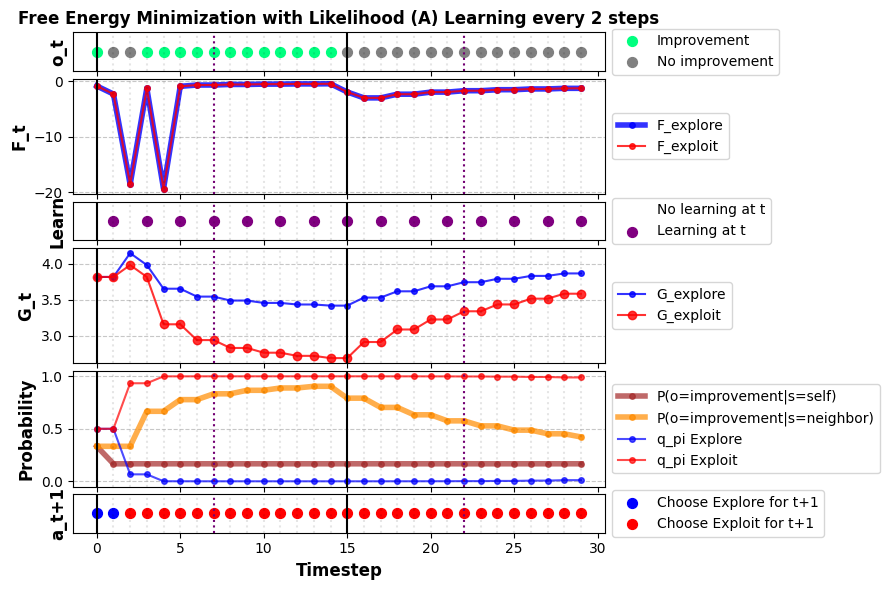

In [ ]:
# Single-agent inference: Simulation 1

import random
random.seed(5)
np.random.seed(0)

# Reset agent and run over T timesteps with context changes
agent = Agent(A = A, B = B, C = C, D = D, E = E, pA = pA,
              inference_algo = 'MMP', policy_len=1,
              inference_horizon=2, sampling_mode = 'full',
              action_selection = 'stochastic'
              )

# Set simulation parameters
learning = 'on'   # 'on' for simulation 1, 'off' for simulation 2
learn_A_after_every_X_timesteps = 2 # 2 for simulation 1

T = 30  # 30 for simulation 1 and simulation 2

force_learn_at_t = 'off' # 'off' for simulation 1, 20 for simulation 2
force_neighbor_context = False  # False for simulaton 1, True for simulation 2
force_neighbor_context_at_t = 20

# Initialize lists for storing results
prob_improve_self_list = []
prob_improve_neighbor_list = []
min_F_list = []
min_G_list = []
action_sampled_id_list = []
q_pi_explore_list = []
q_pi_exploit_list = []
q_pi_list = []
explore_F_list = []
exploit_F_list = []
explore_G_list = []
exploit_G_list = []
obs_list = []
learning_indicator_list = []

for t in range(T):
  # Stage 1: if t=0, return 'improvement' and 'neighbor1' observations...
  if t == 0:
    obs = [0,1]
    context = 'neighbor'
  # then proceed with 'neighbor' context
  elif (t < int(T/2) and t != 0) or (t >= force_neighbor_context_at_t and force_neighbor_context == True):
    if t != 0:
      if action_sampled_id == 0:
        obs = [1,0]
      if action_sampled_id == 1:
        obs = [0,1]
      context = 'neighbor'
    if t == force_neighbor_context_at_t and force_neighbor_context == True:
      print(f"t={t} : forcing neighbor context for rest of timesteps")
  # Stage 2: at halfway, change context to 'self'
  elif t >= int(T/2):
    if action_sampled_id == 0:
      obs = [0,0]
    if action_sampled_id == 1:
      obs = [1,1]
    context = 'self'
  else:
    print(f"t={t}: error")
  if t == 0:
    print(f"t={t} : context = {context}")
  elif t != 0:
    print(f"t={t} : context = {context}, agent.F = {agent.F}, agent.G = {agent.G}, q_pi = {q_pi}, obs = {obs}, action = {action_sampled_id}")
  if t == int(T/2):
    print(f"t={t}: changing context to {context}")
  qs = agent.infer_states(obs)   # returns approx posterior Q(s)
  print(f"qs[0][0][0] = {qs[0][0][0]} --- qs[1][0][0] = {qs[1][0][0]}")  # print comparison over expected states at t per policy (will be equivalent)
  q_pi, neg_G = agent.infer_policies()  # returns posterior over policies and negative EFE
  # stochastically sample actions
  action_sampled = agent.sample_action() # returns vector of action(s)
  action_sampled_id = int(action_sampled[0])
  learning_indicator = 0
  if (t+1) % learn_A_after_every_X_timesteps == 0 and t != 0 and learning == 'on':
    agent.qs = copy.deepcopy(qs[action_sampled_id][1]) # temp set agent's qs only to action chosen, expected at current timestep
    agent.update_A(obs)   # run learning
    agent.qs = copy.deepcopy(qs)   # set qs back to previous, as stored from agent.infer_states(obs)
    learning_indicator = 1
  if t == force_learn_at_t:
    agent.qs = copy.deepcopy(qs[action_sampled_id][1]) # temp set agent's qs only to action chosen, expected at current timestep
    agent.update_A(obs)   # run learning
    agent.qs = copy.deepcopy(qs)   # set qs back to previous, as stored from agent.infer_states(obs)
    learning_indicator = 1
    print(f"t={t}: learning for one step")
  # store results per timestep
  min_F_list.append(np.min(agent.F))
  explore_F_list.append(agent.F[0])
  exploit_F_list.append(agent.F[1])
  min_G_list.append(np.min(agent.G*-1))
  explore_G_list.append(agent.G[0]*-1)
  exploit_G_list.append(agent.G[1]*-1)
  prob_improve_self_list.append(agent.A[0][0][0])
  prob_improve_neighbor_list.append(agent.A[0][0][1])
  q_pi_list.append(q_pi)
  q_pi_explore_list.append(q_pi[0])
  q_pi_exploit_list.append(q_pi[1])
  obs_list.append(obs[0])
  learning_indicator_list.append(learning_indicator)
  action_sampled_id_list.append(action_sampled_id)

# Plot results
plot_single_agent_inference_trial(T, prob_improve_self_list, min_F_list=None, min_G_list=None, q_pi_explore_list=q_pi_explore_list, q_pi_exploit_list=q_pi_exploit_list, explore_G_list=explore_G_list, exploit_G_list=exploit_G_list,
                                  explore_F_list=explore_F_list, exploit_F_list=exploit_F_list, obs_list=obs_list, learning_indicator_list=learning_indicator_list,
                                  is_learning=learning, is_force_learn=force_learn_at_t, force_neighbor_context=force_neighbor_context,force_neighbor_context_at_t=force_neighbor_context_at_t)

t=0 : context = neighbor
qs[0][0][0] = [2.29826198e-15 1.00000000e+00] --- qs[1][0][0] = [2.29826198e-15 1.00000000e+00]
t=1 : context = neighbor, agent.F = [-0.89587973 -0.89587973], agent.G = [-3.81591253 -3.81591253], q_pi = [0.5 0.5], obs = [1, 0], action = 0
qs[0][0][0] = [3.82946062e-16 1.00000000e+00] --- qs[1][0][0] = [3.82946062e-16 1.00000000e+00]
t=2 : context = neighbor, agent.F = [-2.34106561 -2.34106561], agent.G = [-3.81591253 -3.81591253], q_pi = [0.5 0.5], obs = [1, 0], action = 0
qs[0][0][0] = [9.99999986e-01 1.38948043e-08] --- qs[1][0][0] = [9.99999986e-01 1.38948043e-08]
t=3 : context = neighbor, agent.F = [-19.62780536 -19.62780536], agent.G = [-3.81591253 -3.81591253], q_pi = [0.5 0.5], obs = [1, 0], action = 0
qs[0][0][0] = [1.00000000e+00 1.89826629e-18] --- qs[1][0][0] = [1.00000000e+00 1.89826629e-18]
t=4 : context = neighbor, agent.F = [-1.99449203 -1.99449203], agent.G = [-3.81591253 -3.81591253], q_pi = [0.5 0.5], obs = [1, 0], action = 0
qs[0][0][0] = [1.

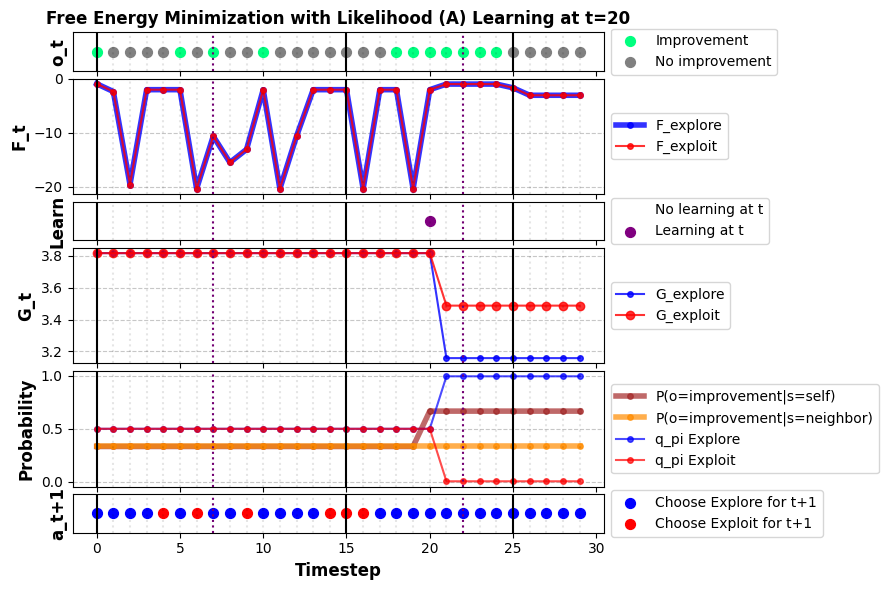

In [ ]:
# Single-agent inference: Simulation 2

import random
random.seed(5)
np.random.seed(0)

# Reset agent and run over T timesteps with context changes
agent = Agent(A = A, B = B, C = C, D = D, E = E, pA = pA,
              inference_algo = 'MMP', policy_len=1,
              inference_horizon=2, sampling_mode = 'full',
              action_selection = 'stochastic'
              )

# Set simulation parameters
learning = 'off'   # 'on' for simulation 1, 'off' for simulation 2
learn_A_after_every_X_timesteps = 2 # 2 for simulation 1

T = 30  # 30 for simulation 1 and simulation 2

force_learn_at_t = 20 # 'off' for simulation 1, 20 for simulation 2
force_neighbor_context = True  # False for simulaton 1, True for simulation 2
force_neighbor_context_at_t = 25   # 25 for simulation 2

# Initialize lists for storing results
prob_improve_self_list = []
prob_improve_neighbor_list = []
min_F_list = []
min_G_list = []
action_sampled_id_list = []
q_pi_explore_list = []
q_pi_exploit_list = []
q_pi_list = []
explore_F_list = []
exploit_F_list = []
explore_G_list = []
exploit_G_list = []
obs_list = []
learning_indicator_list = []

for t in range(T):
  # Stage 1: if t=0, return 'improvement' and 'neighbor1' observations...
  if t == 0:
    obs = [0,1]
    context = 'neighbor'
  # then proceed with 'neighbor' context
  elif (t < int(T/2) and t != 0) or (t >= force_neighbor_context_at_t and force_neighbor_context == True):
    if t != 0:
      if action_sampled_id == 0:
        obs = [1,0]
      if action_sampled_id == 1:
        obs = [0,1]
      context = 'neighbor'
    if t == force_neighbor_context_at_t and force_neighbor_context == True:
      print(f"t={t} : forcing neighbor context for rest of timesteps")
  # Stage 2: at halfway, change context to 'self'
  elif t >= int(T/2):
    if action_sampled_id == 0:
      obs = [0,0]
    if action_sampled_id == 1:
      obs = [1,1]
    context = 'self'
  else:
    print(f"t={t}: error")
  if t == 0:
    print(f"t={t} : context = {context}")
  elif t != 0:
    print(f"t={t} : context = {context}, agent.F = {agent.F}, agent.G = {agent.G}, q_pi = {q_pi}, obs = {obs}, action = {action_sampled_id}")
  if t == int(T/2):
    print(f"t={t}: changing context to {context}")
  qs = agent.infer_states(obs)   # returns approx posterior Q(s)
  print(f"qs[0][0][0] = {qs[0][0][0]} --- qs[1][0][0] = {qs[1][0][0]}")  # print comparison over expected states at t per policy (will be equivalent)
  q_pi, neg_G = agent.infer_policies()  # returns posterior over policies and negative EFE
  # stochastically sample actions
  action_sampled = agent.sample_action() # returns vector of action(s)
  action_sampled_id = int(action_sampled[0])
  learning_indicator = 0
  if (t+1) % learn_A_after_every_X_timesteps == 0 and t != 0 and learning == 'on':
    agent.qs = copy.deepcopy(qs[action_sampled_id][1]) # temp set agent's qs only to action chosen, expected at current timestep
    agent.update_A(obs)   # run learning
    agent.qs = copy.deepcopy(qs)   # set qs back to previous, as stored from agent.infer_states(obs)
    learning_indicator = 1
  if t == force_learn_at_t:
    agent.qs = copy.deepcopy(qs[action_sampled_id][1]) # temp set agent's qs only to action chosen, expected at current timestep
    agent.update_A(obs)   # run learning
    agent.qs = copy.deepcopy(qs)   # set qs back to previous, as stored from agent.infer_states(obs)
    learning_indicator = 1
    print(f"t={t}: learning for one step")
  # store results per timestep
  min_F_list.append(np.min(agent.F))
  explore_F_list.append(agent.F[0])
  exploit_F_list.append(agent.F[1])
  min_G_list.append(np.min(agent.G*-1))
  explore_G_list.append(agent.G[0]*-1)
  exploit_G_list.append(agent.G[1]*-1)
  prob_improve_self_list.append(agent.A[0][0][0])
  prob_improve_neighbor_list.append(agent.A[0][0][1])
  q_pi_list.append(q_pi)
  q_pi_explore_list.append(q_pi[0])
  q_pi_exploit_list.append(q_pi[1])
  obs_list.append(obs[0])
  learning_indicator_list.append(learning_indicator)
  action_sampled_id_list.append(action_sampled_id)

# Plot results
plot_single_agent_inference_trial(T, prob_improve_self_list, min_F_list=None, min_G_list=None, q_pi_explore_list=q_pi_explore_list, q_pi_exploit_list=q_pi_exploit_list, explore_G_list=explore_G_list, exploit_G_list=exploit_G_list,
                                  explore_F_list=explore_F_list, exploit_F_list=exploit_F_list, obs_list=obs_list, learning_indicator_list=learning_indicator_list,
                                  is_learning=learning, is_force_learn=force_learn_at_t, force_neighbor_context=force_neighbor_context,force_neighbor_context_at_t=force_neighbor_context_at_t)

## NK Landscape

In [ ]:
# NK Landscape functions
import random
import numpy as np
import pandas as pd

def create_nk_landscape(N=10, K=5, max_fitness=100, initial_fitness_limit=20, seed=0):
    random.seed(seed) # Set seed for reproducibility
    N = N  # Number of elements
    K = K  # Interdependence parameter
    max_fitness = max_fitness
    initial_fitness_limit = initial_fitness_limit

    # Define the fitness function
    def get_fitness(bitstring, K):
        fitness = 0
        for i in range(N):
            # Get the indices of the K elements that influence the fitness contribution of element i
            indices = [i] + [(i+j+1) % N for j in range(1, K+1)]

            # Calculate the fitness contribution of element i based on its value and the values of the K influencing elements
            fitness_contribution = sum(bitstring[j] for j in indices)
            # Introduce randomness by multiplying with a random weight
            fitness_contribution *= random.uniform(0, 1)
            fitness += fitness_contribution
        return fitness

    # Generate all possible bitstrings of length N
    bitstrings = [list(map(int, list(np.binary_repr(i, N)))) for i in range(2**N)]

    # Calculate and store the fitness value for each bitstring
    fitness_values_original = [get_fitness(bitstring, K) for bitstring in bitstrings]
    # Normalize values
    min_val = min(fitness_values_original)
    max_val = max(fitness_values_original)
    fitness_values = [(val - min_val) / (max_val - min_val) * max_fitness for val in fitness_values_original]

    bitstrings_strings = [bitstring_to_string(bitstring) for bitstring in bitstrings]
    fitness_df = pd.DataFrame({'solution': bitstrings_strings, 'fitness': fitness_values}).reset_index(drop=True)  #note: ordering is based on bitstring similarity
    fitness_initial_df = fitness_df[fitness_df['fitness'] < initial_fitness_limit]
    fitness_initial_df['initial_fitness'] = fitness_initial_df['fitness']
    fitness_df = fitness_df.merge(fitness_initial_df, on = ['solution','fitness'], how = 'left')

    return fitness_df, fitness_initial_df

def bitstring_to_string(bitstring):
    """
    Convert a bitstring (list of 0s and 1s) into a string.
    """
    return ''.join(map(str, bitstring))

def string_to_bitstring(string):
    """
    Convert a string into a bitstring (list of 0s and 1s).
    """
    return [int(char) for char in string]

def get_neighbors(bitstring):
    """
    Generate all neighbors of a given bitstring by flipping one bit at a time.

    Args:          bitstring (list): A list of 0s and 1s representing a bitstring.
    Returns:
        list: A list of bitstrings representing the neighbors.
    """
    neighbors = []
    for i in range(len(bitstring)):
        neighbor = bitstring.copy()
        neighbor[i] = 1 - neighbor[i]  # Flip the i-th bit
        neighbors.append(neighbor)
    return neighbors

def find_local_optima(fitness_df):
    """
    Find the local optima in the given fitness landscape.

    Args:
        fitness_df (pandas.DataFrame): A DataFrame containing the bitstrings and their fitness values.

    Returns:
        list: A list of bitstrings representing the local optima.
    """
    local_optima = []
    for _, row in fitness_df.iterrows():
        bitstring = string_to_bitstring(row['solution'])
        neighbors = [string_to_bitstring(neighbor) for neighbor in fitness_df['solution'].tolist() if sum(np.array(bitstring) != np.array(string_to_bitstring(neighbor))) == 1]
        neighbor_fitness = [fitness_df.loc[fitness_df['solution'] == bitstring_to_string(neighbor), 'fitness'].values[0] for neighbor in neighbors]
        is_local_optimum = True
        for neighbor_fit in neighbor_fitness:
            if row['fitness'] < neighbor_fit:
                is_local_optimum = False
                break
        if is_local_optimum:
            #local_optima.append(bitstring)
            local_optima.append(bitstring_to_string(bitstring))
    local_optima_df = pd.DataFrame(local_optima, columns=['solution']).merge(fitness_df, on = 'solution', how = 'left')
    local_optima_df.loc[:,'local_optima_fitness'] = local_optima_df.loc[:,'fitness']
    local_optima_df = fitness_df.merge(local_optima_df[['solution','local_optima_fitness']], on = 'solution', how = 'left')
    return local_optima_df

<ipython-input-7-5d9e4a40d1ee>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fitness_initial_df['initial_fitness'] = fitness_initial_df['fitness']


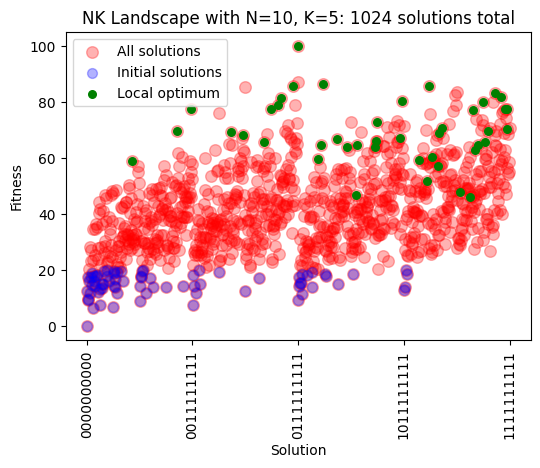

,solution,fitness,initial_fitness,local_optima_fitness
0,0000000000,0.000000,0.000000,NaN
1,0000000001,12.327238,12.327238,NaN
2,0000000010,9.770710,9.770710,NaN
3,0000000011,17.649014,17.649014,NaN
4,0000000100,9.395342,9.395342,NaN
...,...,...,...,...
1019,1111111011,68.442818,NaN,NaN
1020,1111111100,54.425478,NaN,NaN
1021,1111111101,54.838593,NaN,NaN
1022,1111111110,58.542846,NaN,NaN


In [ ]:
# Plot 2D NK landscape
import matplotlib.pyplot as plt
import numpy as np

def plot_nk_landscape(fitness_df, fitness_initial_df=None, local_optima_df=None, agents_list=None):
  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(6, 4))
  # Plot the landscape
  ax.scatter(range(len(fitness_df)), fitness_df['fitness'], s=70, c='r', marker='o', alpha = 0.3, label = 'All solutions')
  if fitness_initial_df is not None:
    ax.scatter(range(len(fitness_df)), fitness_df['initial_fitness'], s=50, c='b', marker='o', alpha=0.3, label = 'Initial solutions')
  if local_optima_df is not None:
    ax.scatter(range(len(local_optima_df)), local_optima_df['local_optima_fitness'], s=30, c='green', marker = 'o', alpha=1.0, label = 'Local optimum')
  # Set axis labels and title
  ax.set_xlabel('Solution')
  ax.set_ylabel('Fitness')
  ax.set_title(f'NK Landscape with N={N}, K={K}: {len(fitness_df)} solutions total')
  # Set x-ticks with solution strings
  num_ticks = 5
  tick_indices = np.linspace(0, len(fitness_df)-1, num_ticks, dtype=int)
  ax.set_xticks(tick_indices)
  ax.set_xticklabels([fitness_df['solution'].iloc[i] for i in tick_indices], rotation=90)
  ax.legend()
  # Show the plot
  plt.show()

# Create nk landscape
N = 10
K = 5
max_fitness=100
initial_fitness_limit= max_fitness / 5
fitness_df, fitness_initial_df = create_nk_landscape(N=N, K=K, max_fitness=max_fitness, initial_fitness_limit=initial_fitness_limit, seed = 0)
local_optima_df = find_local_optima(fitness_df)
plot_nk_landscape(fitness_df, fitness_initial_df=fitness_initial_df, local_optima_df=local_optima_df)
display(local_optima_df)

## Network connections : create_network()

Creating random network of 10 agents with p=1.0
all_connections:
{0: [[1, 2, 3, 4, 5, 6, 7, 8, 9], 0], 1: [[0, 2, 3, 4, 5, 6, 7, 8, 9], 0], 2: [[0, 1, 3, 4, 5, 6, 7, 8, 9], 0], 3: [[0, 1, 2, 4, 5, 6, 7, 8, 9], 0], 4: [[0, 1, 2, 3, 5, 6, 7, 8, 9], 0], 5: [[0, 1, 2, 3, 4, 6, 7, 8, 9], 0], 6: [[0, 1, 2, 3, 4, 5, 7, 8, 9], 0], 7: [[0, 1, 2, 3, 4, 5, 6, 8, 9], 0], 8: [[0, 1, 2, 3, 4, 5, 6, 7, 9], 0], 9: [[0, 1, 2, 3, 4, 5, 6, 7, 8], 0]}


,source,target,subnetwork_index,nsource,ntarget
0,0,1,0,n0,n1
1,0,2,0,n0,n2
2,0,3,0,n0,n3
3,0,4,0,n0,n4
4,0,5,0,n0,n5


Neighbor count min-max = 9-9


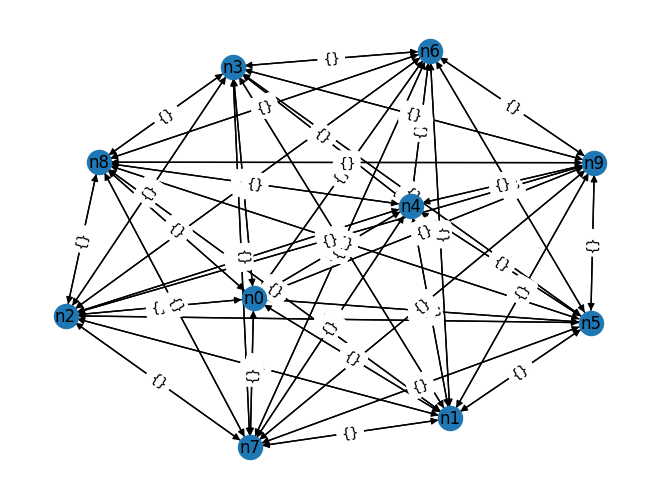

Creating subgroups network of 10 split into 2 groups of 5
all_connections:
{0: [[1, 2, 3, 4], 0], 1: [[0, 2, 3, 4], 0], 2: [[0, 1, 3, 4], 0], 3: [[0, 1, 2, 4], 0], 4: [[0, 1, 2, 3], 0], 5: [[6, 7, 8, 9], 1], 6: [[5, 7, 8, 9], 1], 7: [[5, 6, 8, 9], 1], 8: [[5, 6, 7, 9], 1], 9: [[5, 6, 7, 8], 1]}


,source,target,subnetwork_index,nsource,ntarget
0,0,1,0,n0,n1
1,0,2,0,n0,n2
2,0,3,0,n0,n3
3,0,4,0,n0,n4
4,1,0,0,n1,n0


Neighbor count min-max = 4-4


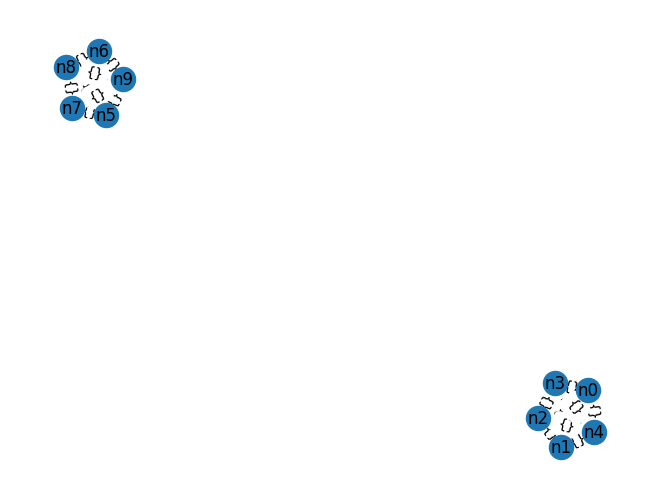

In [ ]:
# Network connections
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)
def create_network(num_agents=10, num_neighbors=None, network_type = 'random', p=1.0, seed = 0, graph_details=True, N=6, M=5):
  """
  num_agents: (int) number of agents in network (if 'random')
  num_neighbors: (deprecated)
  network_type: 'random' for Erdos-Renyi random network; 'subgroups' for N subnetworks of M agents each
  p: (float)
  """
  np.random.seed(seed)
  if network_type == 'random':
    print(f"Creating {network_type} network of {num_agents} agents with p={p}")
  if network_type == 'subgroups':
    print(f"Creating {network_type} network of {N*M} split into {N} groups of {M}")

  def assign_group_indices(G):
      # Find connected components
      components = list(nx.connected_components(G))

      # Create a dictionary to map nodes to their group index
      node_to_group = {}
      for idx, component in enumerate(components):
          for node in component:
              node_to_group[node] = idx

      return node_to_group
  # OPTION 1: random (Erdos-Renyi) network
  if network_type == 'random':
      num_agents = num_agents
      p = p
      G = nx.erdos_renyi_graph(n=num_agents, p=p, seed=seed) # Create a random Erdos-Renyi undirected graph
      node_to_group = assign_group_indices(G) # Assign group indices

      all_connections = {}
      for i in range(num_agents):
          neighbors = list(G.neighbors(i))
          group_index = node_to_group[i]
          all_connections[i] = [neighbors, group_index]

      if graph_details == True:
          print("all_connections:")
          print(all_connections)

  ### OPTION 2: Equal subgroups (subnetworks)
  if network_type == 'subgroups':
    N = N  # Number of subnetworks
    M = M # Number of nodes per subnetwork
    G = nx.Graph() # Create a new graph
    # Create N subnetworks of M nodes each
    node_dict = {}
    subnetwork_index = 0
    node_index = 0
    for i in range(N):
        subnetwork_nodes = list(range(node_index, node_index + M))
        G.add_nodes_from(subnetwork_nodes)

        # Add edges within the subnetwork
        for j in range(M):
            node = subnetwork_nodes[j]
            neighbors = [subnetwork_nodes[k] for k in range(M) if k != j]
            node_dict[node] = [neighbors, subnetwork_index]
            for neighbor in neighbors:
                G.add_edge(node, neighbor)

        node_index += M
        subnetwork_index += 1
    all_connections = node_dict
    if graph_details == True:
      print("all_connections:")
      print(all_connections)

  ### create a df containing all neighbors structured as 'target'->'source' for networkx graph
  df_all_connections = pd.DataFrame()

  #if network_type == 'subgroups':
  if network_type == 'random' or network_type == 'subgroups':
    for i in all_connections.keys():
        for neighbor in all_connections[i][0]:  # Iterate over the neighbors list directly
            subnetwork_index = all_connections[i][1]
            row = pd.DataFrame({'source': i, 'target': neighbor, 'subnetwork_index': subnetwork_index}, index=[0])
            df_all_connections = pd.concat([df_all_connections, row], ignore_index=True)



  for i in range(len(df_all_connections)):
    df_all_connections.loc[i,'nsource'] = 'n' + str(df_all_connections.loc[i,'source'])
    df_all_connections.loc [i,'ntarget'] = 'n' + str(df_all_connections.loc[i,'target'])
  if graph_details == True:
    with pd.option_context('display.max_rows',None):
      display(df_all_connections.head(5))

  neighbor_counts = pd.DataFrame(df_all_connections['source'].value_counts()).reset_index()
  if graph_details == True:
    print(f"Neighbor count min-max = {neighbor_counts['count'].min()}-{neighbor_counts['count'].max()}")
  if graph_details == True:
    df = df_all_connections
    # Create a graph from the DataFrame
    G = nx.from_pandas_edgelist(df, source='nsource', target='ntarget', #edge_attr='weight',
                                create_using=nx.DiGraph())
    # Draw and display the graph
    pos = nx.spring_layout(G)
    #pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    if network_type == 'fixed' or network_type == 'subgroups':
      edge_labels = nx.get_edge_attributes(G, 'weight') # currently only compatible w OPTION 1
    nx.draw_networkx_edge_labels(G, pos) #   edge_labels=edge_labels)

    plt.axis('off')
    plt.show()

  return all_connections, df_all_connections

all_connections, df_all_connections = create_network(num_agents=10, num_neighbors=None, network_type = 'random', p=1.0, seed = 0, graph_details=True, N=3, M=4)
all_connections, df_all_connections = create_network(num_agents=10, num_neighbors=None, network_type = 'subgroups', p=1.0, seed = 0, graph_details=True, N=2, M=5)

In [ ]:
# Set agent params using network connections

def create_agents_params(all_connections):
  agents_params = {}
  # For each agent:
  for agent_i in list(all_connections.keys()):
    #try:
      # Initialize empty dictionary per agent (we will name each change 'n' + their index number, e.g, 'n0', 'n8')
      agents_params['n'+str(agent_i)] = {}
      agents_params['n'+str(agent_i)]['neighbors_idx'] = all_connections[agent_i][0]   # store all neighbors' index numbers
      agents_params['n'+str(agent_i)]['local_idx'] = [agent_i] + all_connections[agent_i][0]    # store all index numbers for neighbors and agent itself)
      agents_params['n'+str(agent_i)]['subnetwork'] = all_connections[agent_i][1]   # store which subnetwork agent is in if applicable
      agents_params['n'+str(agent_i)]['neighbors'] = ['n' + str(j) for j in list(all_connections[agent_i][0])]  #collect neighbors, adding 'n' prefix

      # Hidden states
      agents_params['n'+str(agent_i)]['attention_state_names'] = ['self'] + agents_params['n'+str(agent_i)]['neighbors'] #attention states: self and neighbors
      agents_params['n'+str(agent_i)]['num_states'] = [len(agents_params['n'+str(agent_i)]['attention_state_names'])] #store num of states in 'attention' hidden state factor
      agents_params['n'+str(agent_i)]['num_factors'] = len(agents_params['n'+str(agent_i)]['num_states']) #store num of hidden state factors

      # Observations
      agents_params['n'+str(agent_i)]['outcome_obs_names'] = ['improvement','no improvement','unobserved'] # outcome modality
      agents_params['n'+str(agent_i)]['attention_obs_names'] = ['self'] + agents_params['n'+str(agent_i)]['neighbors'] # attention modality (self + one per neighbor)
      agents_params['n'+str(agent_i)]['num_obs'] = [len(agents_params['n'+str(agent_i)]['outcome_obs_names']), len(agents_params['n'+str(agent_i)]['attention_obs_names'])]
      agents_params['n'+str(agent_i)]['num_modalities'] = len(agents_params['n'+str(agent_i)]['num_obs'])

      # Actions
      agents_params['n'+str(agent_i)]['action_names'] = ['explore'] + ['exploit_' + str(j) for j in agents_params['n'+str(agent_i)]['neighbors']]  # explore + exploit (per neighbor)
      agents_params['n'+str(agent_i)]['num_controls'] = len(agents_params['n'+str(agent_i)]['action_names'])
    # except Exception as e:
    #   print(f"error {agent_i} : {e}")
    #   print(f"{all_connections[agent_i][0]}")

  return agents_params

# View structure of nested dictionary for an individual agent
def inspect_agents(agents_params, agents=['n0','n1']):
  for agent in agents:
    print(f"agent {agent}:")
    for key, value in agents_params[agent].items():
      print(f"{key} : {value}")
    print("")

def view_neighbors(agents_params):
  for agent_i in agents_params:
    print(f"{[agent_i]}: {agents_params[agent_i]['neighbors']}")

In [ ]:
def set_pomdp_variables(agents_params, C_improvement_prefs=np.array([5, -1, 0]), show_details=False, add_pD=False):
  # Define A/B/C/D/E matrices per agent

  # define A per agent
  for agent_i in list(agents_params.keys()):
    # A matrix
    agents_params[agent_i]['A'] = utils.obj_array(agents_params[agent_i]['num_modalities'])
    # A[0] = outcomes modality
    agents_params[agent_i]['A'][0] = np.zeros( ( len(agents_params[agent_i]['outcome_obs_names']), len(agents_params[agent_i]['attention_state_names']) ) )
    for attention_state in range(len(agents_params[agent_i]['attention_state_names'])):
      agents_params[agent_i]['A'][0][:,attention_state] = utils.norm_dist(np.ones(shape=len(agents_params[agent_i]['outcome_obs_names'])))    # generate uniform distribution
    # A[1] = attention modality
    agents_params[agent_i]['A'][1] =np.zeros( ( len(agents_params[agent_i]['attention_obs_names']), len(agents_params[agent_i]['attention_state_names']) ) )
    for attention_state in range(len(agents_params[agent_i]['attention_state_names'])):
      agents_params[agent_i]['A'][1][attention_state,attention_state] = 1   # attention state levels and attention obs levels are parallel, so we can set prob to 1 to link self-self, nX-nX, etc.
      agents_params[agent_i]['A'][1][:,attention_state] = utils.norm_dist(agents_params[agent_i]['A'][1][:,attention_state])
    if show_details == True:
      if agent_i == 'n0':
        print(f"agents_params['n0']['num_modalities'] = {agents_params['n0']['num_modalities']}")
        print(f"agents_params['n0']['A'][1] = {agents_params['n0']['A'][1]}")
        for modality_i in range(agents_params[agent_i]['num_modalities']):
          print(f"utils.is_normalized(agents_params[{agent_i}]['A'][{modality_i}]) = {utils.is_normalized(agents_params[agent_i]['A'][modality_i])}")


  # define B per agent   --- **regardless of current state, if agent chooses 'exploit_nX', then next state is 'attend to nX', i.e. agent has full certainty over 'attention' state-action mappings
  for agent_i in list(agents_params.keys()):
    agents_params[agent_i]['B'] = utils.obj_array(agents_params[agent_i]['num_factors'])
    agents_params[agent_i]['B'][0] = np.zeros( ( len(agents_params[agent_i]['attention_state_names']), len(agents_params[agent_i]['attention_state_names']), len(agents_params[agent_i]['action_names']) ) )
    att_state_names_test = len(agents_params[agent_i]['attention_state_names'])
    action_names_test = len(agents_params[agent_i]['action_names'])

    for action_i in range(len(agents_params[agent_i]['action_names'])):
        agents_params[agent_i]['B'][0][:,:,action_i][action_i] = 1

    if show_details == True:
      if agent_i == 0:
        print(f"utils.is_normalized(agents_params[{agent_i}]['B'][0]) = {utils.is_normalized(agents_params[agent_i]['B'][0])}")

  # define C per agent
  for agent_i in list(agents_params.keys()):
    agents_params[agent_i]['C'] = utils.obj_array_zeros(agents_params[agent_i]['num_obs'])
    agents_params[agent_i]['C'][0] = utils.norm_dist(softmax(C_improvement_prefs))   # how much agents (dys)prefers 'improvement', 'no_improvement', 'unobserved'
    #agents_params[agent_i]['C'][1] = utils.norm_dist(np.random.uniform(size=len(agents_params[agent_i]['attention_obs_names'])))   # previous, changed 7/7/2024
    agents_params[agent_i]['C'][1] = utils.norm_dist(np.ones(shape=len(agents_params[agent_i]['attention_obs_names'])))
    if show_details == True:
      if agent_i == 0:
        print(agents_params[agent_i]['C'])
        print(f"agents_params[n0]['C'][1] = {agents_params[agent_i]['C'][1]}")
        for modality_i in range(agents_params[agent_i]['num_modalities']):
          print(f"utils.is_normalized(agents_params[{agent_i}]['C'][{modality_i}]) = {utils.is_normalized(agents_params[agent_i]['C'][modality_i])}")

  # define D per agent
  for agent_i in list(agents_params.keys()):
    agents_params[agent_i]['D'] = utils.obj_array(agents_params[agent_i]['num_factors'])
    agents_params[agent_i]['D'][0] = utils.norm_dist(np.ones(shape=agents_params[agent_i]['num_states'][0])) # new 7/7/2024

    if show_details == True:
      if agent_i == 0:
        print(f"utils.is_normalized(agents_params[{agent_i}]['D'][0]) = {utils.is_normalized(agents_params[agent_i]['D'][0])}")

  # define E per agent
  for agent_i in list(agents_params.keys()):
    agents_params[agent_i]['E'] = utils.norm_dist(np.ones(shape=agents_params[agent_i]['num_controls']))
    if show_details == True:
      if agent_i == 0:
        print(f"utils.is_normalized(agents_params[{agent_i}]['E']) = {utils.is_normalized(agents_params[agent_i]['E'])}")

    # learning A
    agents_params[agent_i]['pA'] = utils.dirichlet_like(agents_params[agent_i]['A'], scale = 0.5) # learning likelihood
    agents_params[agent_i]['pB'] = utils.dirichlet_like(agents_params[agent_i]['B'], scale = 1.0) # learning transitions
    agents_params[agent_i]['pD'] = utils.dirichlet_like(agents_params[agent_i]['D'], scale = 1.0) # learning priors over initial states

  return agents_params

def initialize_agents(agents_params, inference_horizon=1, inference_algo='MMP',policy_len=1, add_pD=True):   #sophisticated=False, save_belief_hist=True,
  # Initializing agents and storing into agents_list dict
  agents_list = {}
  for agent_i in list(agents_params.keys()):
    agents_list[agent_i] = Agent(A = agents_params[agent_i]['A'],
                                          B = agents_params[agent_i]['B'],
                                          C = agents_params[agent_i]['C'],
                                          D = agents_params[agent_i]['D'],
                                          E = agents_params[agent_i]['E'],
                                          pA = agents_params[agent_i]['pA'],  # added
                                          pB = agents_params[agent_i]['pB'],
                                          pD = agents_params[agent_i]['pD'],  # added
                                          inference_algo = inference_algo,
                                          policy_len=policy_len,
                                          #sophisticated = sophisticated,
                                          #save_belief_hist = save_belief_hist,
                                         inference_horizon=inference_horizon,
                                          sampling_mode = 'full', action_selection = 'stochastic')
    if add_pD == True:
      agents_list[agent_i].pD = agents_params[agent_i]['pD']

  return agents_list

## Initialize solutions and create NK landscapes for simulation

In [ ]:
# Function to set initial solutions for agents

def initialize_solutions(agents_list, fitness_initial_df, fitness_df, seed=0):
  # Initialize agents with solutions/fitness values (working but freezes on n28 fitness lookup)
  random.seed(seed)
  for agent_i in agents_list:
    agents_list[agent_i].current_solution = random.choice(fitness_initial_df['solution'].tolist()) # sample random row of initial solutions
    agents_list[agent_i].current_fitness = fitness_df[fitness_df['solution'].isin([agents_list[agent_i].current_solution])]['fitness'].values[0]
    print(f"agent {agent_i} : {agents_list[agent_i].current_solution} with fitness {agents_list[agent_i].current_fitness}")

  return agents_list


In [ ]:
# Create two NK landscapes (same N and K, different seeds) for two-stage simulations
N = 10
K = 5
max_fitness=100
initial_fitness_limit= max_fitness / 5
fitness_df, fitness_initial_df = create_nk_landscape(N=N, K=K, max_fitness=max_fitness, initial_fitness_limit=initial_fitness_limit, seed=0)

# Initialize 2nd nk landscape with different seed for two-stage loop
fitness_df_two, fitness_initial_df_two = create_nk_landscape(N=N, K=K, max_fitness=max_fitness, initial_fitness_limit=initial_fitness_limit, seed=1)

<ipython-input-7-5d9e4a40d1ee>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fitness_initial_df['initial_fitness'] = fitness_initial_df['fitness']
<ipython-input-7-5d9e4a40d1ee>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fitness_initial_df['initial_fitness'] = fitness_initial_df['fitness']


## Function for creating a full parameter sweep

In [ ]:
# Function for preparing a full parameter sweep

def create_agents_full_sweep(fitness_df, fitness_initial_df, num_agents=10, num_neighbors=None, network_type='random', p=0.2, N=2, M=2, C_improvement_prefs=np.array([5, -1, 0]), seed=0, sophisticated=False, inference_algo='MMP', inference_horizon=1,policy_len=1,
                             show_details=False
                             #save_belief_hist=True):
                            ):
  all_connections, df_all_connections = create_network(num_agents=num_agents, num_neighbors=num_neighbors, network_type=network_type, p=p, N=N, M=M, seed=seed)
  agents_params = create_agents_params(all_connections=all_connections)
  agents_params = set_pomdp_variables(agents_params, C_improvement_prefs=C_improvement_prefs, show_details=False)
  agents_list = initialize_agents(agents_params, inference_horizon=inference_horizon, inference_algo=inference_algo,policy_len=policy_len)   #,sophisticated=sophisticated, save_belief_hist=save_belief_hist)
  agents_list = initialize_solutions(agents_list=agents_list, fitness_initial_df=fitness_initial_df, fitness_df=fitness_df, seed=0)
  return agents_params, agents_list

## Function for defining and running the Active Inference loop

In [ ]:
import pandas as pd   # ADDED!!!

def run_active_inference_loop(agents_list, agents_params, fitness_df, T = 5, seed=0, error_rate=0, first_stage=False, learn_A_after_every_X_timesteps = 1, error_monitoring=False):
  """
  Define Active Inference loop:

  agents_list : list of constructed active inference agents (list)
  agents_params : dictionary of agents' parameters (dict)
  fitness_df : DataFrame containing all solution and fitnesse pairings for an NK landscape (pandas DataFrame)
  T : duration (number of timesteps) to run the loop (int)
  seed : set seed for reproducibility (int)
  error_rate : set error-in-copying rate (float in range [0,1] inclusive)
  first_stage : True/False indicator for if the loop is being run as a first stage; determines if agents should be forced to 'explore' at t=1
  learn_A_after_every_X_timesteps : number of timesteps to pass before agent updates their A matrix (int)
  error_monitoring : True/False indicator for if error-related output should be printed to the console for debugging purposes
  """

  print(f"{len(agents_params)} agents over {T} timesteps:")

  # Set lists for recording into results
  time_steps = []
  min_fitness_list = []
  max_fitness_list = []
  average_fitness_list = []
  number_of_unique_solutions_list = []
  n0_prev_fitness_list = []
  n0_action_list = []
  n0_new_fitness_list = []
  n0_solution_list = []
  n0_change_list = []
  n0_solution_outer_list = []
  n0_qs_list = []
  n0_q_pi_list = []
  n0_efe_list = []
  n0_A_explore_belief_list = []
  all_agent_actions_list = []
  all_agent_errors_list = []
  all_agents_A_explore_beliefs_list = []
  all_agents_A_explore_beliefs_dist_list = []
  avg_efe_list = []
  avg_vfe_list = []
  avg_top_50_fitness_list = []
  avg_bottom_50_fitness_list = []
  learning_indicator_list = []

  # Group-results initial dicts
  # Create a new nested dictionary with unique values as keys
  unique_subnetworks = set()
  for agent_i in agents_params.keys():      # result_dict.keys():
    print(agent_i)
    unique_subnetworks.add(agents_params[agent_i]['subnetwork'])
  print(f"unique_subnetworks = {unique_subnetworks}")
  subnetwork_dict_structure = {subnetwork: {
      'avg_all_agent_actions': [], 'number_of_unique_solutions' : [], 'min_fitness': [], 'max_fitness': [],
      'avg_bottom_50_fitness' : [], 'avg_top_50_fitness': [], 'average_fitness': [],
      'avg_all_agent_errors' : [],'all_agents_A_explore_beliefs' : [], 'avg_efe': [],'avg_vfe' : []} for subnetwork in unique_subnetworks}
  subnetwork_dict = copy.deepcopy(subnetwork_dict_structure)

  random.seed(seed)
  # Initial observatons
  if error_monitoring:
    print(f"Start: gathering all solutions & fitnesses start")
  all_solutions_start = [agents_list[agent_i].current_solution for agent_i in agents_list]  # collect all of agents' current solutions into a list
  all_fitnesses_start = [agents_list[agent_i].current_fitness for agent_i in agents_list]   # collect all of agents' current fitnesses into a list

  for t in range(T):
    if error_monitoring:
      print(f"Starting t={t}---------------------------------------")
    #print(f"t={t}-------------------------------------------------------------")
    if t % (0.1 * T) == 0:  # Check if t is a multiple of 10% of T
      print(f"Running time step {t}/{T}")
    try:
      # Get all solutions, set agent's new fitnesses, and get all fitnesses at start of each timestep (remember to collect the final ones after the 'for t in range(T):' call)
      all_solutions = [agents_list[agent_i].current_solution for agent_i in agents_list]
      #for agent_i in agents_list:
        #agents_list[agent_i].current_fitness = fitness_df[fitness_df['solution'].isin([agents_list[agent_i].current_solution])]['fitness'].values[0]  # is this necessary?
        #agents_list[agent_i].current_fitness = fitness_df[fitness_df['solution'].isin([agents_list[agent_i].current_solution])]['fitness'].values[0]
        #print(f"Error check: {agents_list[agent_i].current_fitness}")
      all_fitnesses = [agents_list[agent_i].current_fitness for agent_i in agents_list]
      all_agent_actions_at_t_list = []
      all_agent_errors_at_t_list = []
      all_agents_A_explore_beliefs_at_t_list = []
      all_agents_efe_at_t_list = []
      all_agents_vfe_at_t_list = []

      # Group-results initialize dict for time t
      subnetwork_dict_at_t = copy.deepcopy(subnetwork_dict_structure)


      for agent_i in agents_list:
        # Action selection
        if t == 0 and first_stage == True:
          action_sampled_id = 0     # If start of entire trial, force 'explore' -- for random, change to ```action_sampled_id = random.randrange(agents_params[agent_i]['num_controls'])```
        else:        # for every run after first time step
          action_sampled = agents_list[agent_i].sample_action()
          action_sampled_id = int(action_sampled[0])
          #if agent_i == 'n0':
            #print(f"n0 action_sampled = {action_sampled}, action_sampled_id = {action_sampled_id}")
        # `Env` proxy (action -> obs)

        # Explore
        if action_sampled_id == 0:
          try:
            agent_action = 0
            all_agent_actions_at_t_list.append(agent_action)
            prev_solution = agents_list[agent_i].current_solution
            prev_fitness = agents_list[agent_i].current_fitness
            new_solution = string_to_bitstring(agents_list[agent_i].current_solution)   # MODIFIED/ADDED
            mutation_index = random.randrange(len(new_solution))   #randomly choose one of the components in current solution
            new_solution[mutation_index] = 1 - new_solution[mutation_index]  # Flip one bit (specifically the element in 'child' indexed at mutation_index); 1-0=1, 1-1=0
            new_solution = bitstring_to_string(new_solution)  #ADDED
            new_fitness = fitness_df[fitness_df['solution'].isin([new_solution])]['fitness'].values[0]
            # If explored solution's fitness is better, keep as new solution
            if new_fitness > prev_fitness:
              agents_list[agent_i].current_solution = new_solution
              agents_list[agent_i].current_fitness = new_fitness
              obs = [0, 0]   # 'improvement' from attention to 'self'
              if agent_i == 'n0':
                n0_change = 'yes'
            # Else keep previous solution and observe as no improvement
            else:
              obs = [1, 0]   # 'no_improvement' from attention to 'self'
              if agent_i == 'n0':
                n0_change = ''
          except Exception as e:
            print(f"Explore error at {t}, agent {agent_i}: action_sampled_id = {action_sampled_id}, prev_solution = {prev_solution}, prev_fitness = {prev_fitness}, new_solution = {new_solution}, new_fitness = {new_fitness}")
            continue

        # Exploit nX
        elif action_sampled_id != 0:
          try:
            agent_action = 1
            all_agent_actions_at_t_list.append(agent_action)
            #print(f"Error check: Exploit")
            prev_solution = agents_list[agent_i].current_solution
            prev_fitness = agents_list[agent_i].current_fitness
            #print(f"prev_solution = {prev_solution} with fitness {evaluate_fitness(prev_solution)}")
            #local_fitnesses = [all_fitnesses[i] for i in agents_params[agent_i]['local_idx']]  # get agent's local fitnesses (own + neighbors')
            local_solutions = [all_solutions[i] for i in agents_params[agent_i]['local_idx']]
            # Get solution of neighbor that agent sampled
            #attention_solution = copy.deepcopy(local_solutions[action_sampled_id])
            #print(f"attention_solution = {attention_solution}")
            #print(f"attention_solution = {attention_solution}, action_sampled_id = {action_sampled_id}, action_names[action_sampled_id] = {agents_params[agent_i]['action_names'][action_sampled_id]}")

            # For each component of current solution, copy attended neighbor's component with error rate
            attention_solution = copy.deepcopy(local_solutions[action_sampled_id])
            new_solution = string_to_bitstring(prev_solution) #copy.deepcopy(prev_solution)
            num_errors = 0
            for i in range(len(attention_solution)):
              random_val = random.random()
              if random_val > error_rate:
                #print(f"random_val = {random_val}")
                #new_solution[i] = better_solution[i]
                new_solution[i] = attention_solution[i]
              else:
                num_errors += 1
            all_agent_errors_at_t_list.append(num_errors)
            new_solution = bitstring_to_string(new_solution)
            new_fitness = fitness_df[fitness_df['solution'].isin([new_solution])]['fitness'].values[0]
            if new_fitness > prev_fitness:
              if agent_i == 'n0':
                n0_change = 'yes'
              agents_list[agent_i].current_solution = copy.deepcopy(new_solution)
              agents_list[agent_i].current_fitness = new_fitness
              obs = [0, action_sampled_id]    #agent sees improvement from exploiting particular neighbor
              print(f"agent {agent_i} changed: prev_solution = {prev_solution}, prev_fitness = {prev_fitness}, new_solution = {new_solution}, new_fitness = {new_fitness}")
            else:
              if agent_i == 'n0':
                n0_change = ''
              obs = [1, action_sampled_id] # agent keeps previous solution if 'copied' solution has <= equivalent fitness
          except Exception as e:
            print(f"Exploit error at {t}, agent {agent_i}: action_sampled_id = {action_sampled_id}, error {e}")
            continue
        if agent_i == 'n0':
            n0_new_fitness_list.append(agents_list['n0'].current_fitness)
            n0_action_list.append(agents_params['n0']['action_names'][action_sampled_id])
            n0_solution_list.append(agents_list['n0'].current_solution)
            n0_change_list.append(n0_change)


        # Infer states
        try:
          qs = agents_list[agent_i].infer_states(obs)
        except Exception as e:
          print(f"t={t} agent {agent_i} infer_states(obs) error : {e}")
        # Learning
        try:
          # learn after every X timesteps (must be numeric)
          if isinstance(learn_A_after_every_X_timesteps, (int,float)):
            if (t+1) % learn_A_after_every_X_timesteps == 0 and t != 0:
              agents_list[agent_i].qs = copy.deepcopy(qs[action_sampled_id][0])   # temporarily set agent's qs to specific posterior dist over states given action chosen for current timestep
              agents_list[agent_i].update_A(obs)
              agents_list[agent_i].qs = copy.deepcopy(qs)   # change qs back to the output of infer_states(obs)
              learning_indicator = 1
            else:
              learning_indicator = 0
          if agent_i == 'n0':
            n0_A_explore_belief_list.append(agents_list[agent_i].A[0][0][0])   # structure of A is [modality][observation][self/neighbor]
          all_agents_A_explore_beliefs_at_t_list.append(agents_list[agent_i].A[0][0][0])
        except Exception as e:
          print(f"Error with update_A(obs) : {e}")
        # Infer policies
        try:
          q_pi, efe = agents_list[agent_i].infer_policies()
        except Exception as e:
          print(f"t={t} agent {agent_i} infer_policies error : {e}")
        #print(f"q_pi[0], efe[0] = {q_pi[0]}, {efe[0]}")
        if agent_i == 'n0':
          n0_qs_list.append(qs)
          n0_q_pi_list.append(q_pi)
          n0_efe_list.append(efe)

        #Group-results : store individual agent's results by subnetwork into temp subnetwork_dict_at_t
        try:
          for subnetwork_i in unique_subnetworks:
            if agents_params[agent_i]['subnetwork'] == subnetwork_i:
              #subnetwork_dict_at_t[subnetwork_i]['avg_efe'].append(np.min(copy.deepcopy(agents_list[agent_i].G)))
              subnetwork_dict_at_t[subnetwork_i]['avg_efe'].append(copy.deepcopy(agents_list[agent_i].G*-1)[0])
              subnetwork_dict_at_t[subnetwork_i]['avg_vfe'].append(np.min(copy.deepcopy(agents_list[agent_i].F)))
              subnetwork_dict_at_t[subnetwork_i]['average_fitness'].append(agents_list[agent_i].current_fitness)  # used for computing min/max/avg/top 50/bottom 50 fitness metrics
              subnetwork_dict_at_t[subnetwork_i]['number_of_unique_solutions'].append(agents_list[agent_i].current_solution)
              subnetwork_dict_at_t[subnetwork_i]['avg_all_agent_errors'].append(num_errors if action_sampled_id != 0 else 0)
              subnetwork_dict_at_t[subnetwork_i]['avg_all_agent_actions'].append(0 if action_sampled_id == 0 else 1)
              subnetwork_dict_at_t[subnetwork_i]['all_agents_A_explore_beliefs'].append(agents_list[agent_i].A[0][0][0])
              #print(f"t={t} agent_i={agent_i} in subnetwork{agents_params[agent_i]['subnetwork']} : subnetwork_dict_at_t[subnetwork_i]['avg_efe']={subnetwork_dict_at_t[subnetwork_i]['avg_efe']}")
        except Exception as e:
          print(f"ERROR at t={t}/{T} store agent_i results by subnetwork into temp subnetwork_dict_at_t : {e}")

      try:
        # store outputs for all agents at end of timestep
        all_solutions = [copy.deepcopy(agents_list[agent_i].current_solution) for agent_i in agents_list]
        all_fitnesses = [agents_list[agent_i].current_fitness for agent_i in agents_list]
        all_efe_min = [copy.deepcopy(agents_list[agent_i].G*-1)[0] for agent_i in agents_list]  # multiply by -1 (infer_policies() returned negative G) and extract G for 'explore'
        all_vfe_min = [np.min(copy.deepcopy(agents_list[agent_i].F)) for agent_i in agents_list]
        sorted_fitnesses = sorted(all_fitnesses)
        num_to_keep = math.ceil(len(all_fitnesses) * 0.5)   # num of fitnesses to keep for determining top/bottom 50% of fitness values
        avg_bottom_50_fitness_list.append(np.mean(sorted_fitnesses[:num_to_keep]))
        avg_top_50_fitness_list.append(np.mean(sorted_fitnesses[num_to_keep:]))
        avg_efe_list.append(np.mean(all_efe_min))
        avg_vfe_list.append(np.mean(all_vfe_min))
        learning_indicator_list.append(learning_indicator)

        #print(f"appending to max_fitness_list, min_fitness_list, average_fitness_list")
        max_fitness_list.append(np.max(all_fitnesses))
        min_fitness_list.append(np.min(all_fitnesses))
        average_fitness_list.append(np.mean(all_fitnesses))
        number_of_unique_solutions_list.append(len(set(x for x in all_solutions)))
        time_steps.append(t)
        all_agent_actions_list.append(np.mean(all_agent_actions_at_t_list))
        if len(all_agent_errors_at_t_list) == 0:
          all_agent_errors_list.append(0)
        else:
          all_agent_errors_list.append(np.mean(all_agent_errors_at_t_list))
        all_agents_A_explore_beliefs_list.append(np.mean(all_agents_A_explore_beliefs_at_t_list))
        all_agents_A_explore_beliefs_dist_list.append(all_agents_A_explore_beliefs_at_t_list)
        try:
          #Group-results : append aggregated metrics from time t
          #print(f"subnework_dict_at_t t={t}, with len(subnetwork_dict_at_t[0]['efe])={len(subnetwork_dict_at_t[0]['avg_efe'])} with N-M={N}-{M},unique_subnetworks={unique_subnetworks} after agent_i loop = {subnetwork_dict_at_t}")
          for subnetwork_i in unique_subnetworks:
            # for metric in subnetwork_dict[0].keys():
              subnetwork_dict[subnetwork_i]['avg_efe'].append(np.mean(copy.deepcopy(subnetwork_dict_at_t[subnetwork_i]['avg_efe'])))
              subnetwork_dict[subnetwork_i]['avg_vfe'].append(np.mean(copy.deepcopy(subnetwork_dict_at_t[subnetwork_i]['avg_vfe'])))
              subnetwork_dict[subnetwork_i]['average_fitness'].append(np.mean(copy.deepcopy(subnetwork_dict_at_t[subnetwork_i]['average_fitness'])))
              subnetwork_dict[subnetwork_i]['min_fitness'].append(np.min(copy.deepcopy(subnetwork_dict_at_t[subnetwork_i]['average_fitness'])))
              subnetwork_dict[subnetwork_i]['max_fitness'].append(np.max(copy.deepcopy(subnetwork_dict_at_t[subnetwork_i]['average_fitness'])))
              subnetwork_dict[subnetwork_i]['number_of_unique_solutions'].append(len(set(solution for solution in copy.deepcopy(subnetwork_dict_at_t[subnetwork_i]['number_of_unique_solutions']))))
              subnetwork_dict[subnetwork_i]['avg_all_agent_actions'].append(np.mean(copy.deepcopy(subnetwork_dict_at_t[subnetwork_i]['avg_all_agent_actions'])))
              subnetwork_dict[subnetwork_i]['all_agents_A_explore_beliefs'].append(np.mean(copy.deepcopy(subnetwork_dict_at_t[subnetwork_i]['all_agents_A_explore_beliefs'])))
              num_to_keep = math.ceil(len(subnetwork_dict_at_t[subnetwork_i]['average_fitness']) * 0.5)
              subnetwork_dict[subnetwork_i]['avg_bottom_50_fitness'].append(np.mean(sorted(copy.deepcopy(subnetwork_dict_at_t[subnetwork_i]['average_fitness'])[:num_to_keep])))
              subnetwork_dict[subnetwork_i]['avg_top_50_fitness'].append(np.mean(sorted(copy.deepcopy(subnetwork_dict_at_t[subnetwork_i]['average_fitness'])[num_to_keep:])))
              subnetwork_dict[subnetwork_i]['avg_all_agent_errors'].append(np.mean(copy.deepcopy(subnetwork_dict_at_t[subnetwork_i]['avg_all_agent_errors'])))
        except Exception as e:
          print(f"ERROR t={t}/{T} append aggregated metrics from time t: {e}---------------------------------------")
          print(f"ERROR subnetwork_dict t={t} with, len(subnetwork_dict[0]['efe'])={len(subnetwork_dict[0]['avg_efe'])}, after appending means = {subnetwork_dict}")

      except Exception as e:
        print(f"""Storing outputs error at {t}, agent {agent_i} of {len(agents_list)} with action_sampled_id={action_sampled_id} which is {agents_params[agent_i]['action_names'][action_sampled_id]}
              for local neighbor with local_idx value {agents_params[agent_i]['local_idx'][action_sampled_id]}:
                solution = {copy.deepcopy(agents_list[agent_i].current_solution)}, fitness = {agents_list[agent_i].current_fitness}
                max_fitness = {np.max(all_fitnesses)}, min_fitness = {np.min(all_fitnesses)}, average_fitness={np.mean(all_fitnesses)}
                number_of_unique_solutions = {len(set(tuple(x) for x in all_solutions))}, t={t}
                Storing outputs, {e}, len(all_solutions)={len(all_solutions)}, len(all_fitnesses)={len(all_fitnesses)},
                len(time_steps)={len(time_steps)}, len(max_fitness_list)={len(max_fitness_list)}, len(min_fitness_list)={len(min_fitness_list)},
                len(average_fitness_list)={len(average_fitness_list)}, len(number_of_unique_solutions_list)={len(number_of_unique_solutions_list)},
                len(n0_action_list)={len(n0_action_list)}, len(n0_new_fitness_list)={len(n0_new_fitness_list)}, len(n0_solution_list)={len(n0_change_list)}
                prev_solution = {prev_solution}, prev_fitness = {prev_fitness}, new_solution = {new_solution}, new_fitness = {new_fitness}""")

    except Exception as e:
      print(f"Timestep error at t={t} : {e}")
      continue
  all_solutions_final = copy.deepcopy(all_solutions)
  all_fitnesses_final = copy.deepcopy(all_fitnesses)
  results = pd.DataFrame({'timestep': time_steps, 'max_fitness' : max_fitness_list, 'min_fitness' : min_fitness_list, 'average_fitness' : average_fitness_list,
                          'number_of_unique_solutions' : number_of_unique_solutions_list,
                          'n0 action' : n0_action_list, 'n0 fitness' : n0_new_fitness_list, 'n0 solution' : n0_solution_list,'n0 change' : n0_change_list,
                          'n0 qs' : n0_qs_list, 'n0 q_pi' : n0_q_pi_list, 'n0 efe' : n0_efe_list, 'n0 A' : n0_A_explore_belief_list,
                          'avg_all_agent_actions' : all_agent_actions_list, 'avg_all_agent_errors' : all_agent_errors_list,
                           'all_agents_A_explore_beliefs' : all_agents_A_explore_beliefs_list, 'all_agents_A_explore_beliefs_dist' : all_agents_A_explore_beliefs_dist_list,
                          'avg_bottom_50_fitness' : avg_bottom_50_fitness_list, 'avg_top_50_fitness' : avg_top_50_fitness_list,
                          'avg_efe' : avg_efe_list, 'avg_vfe' : avg_vfe_list, 'learning_indicator' : learning_indicator_list
                          })
  return results, all_solutions_final, all_fitnesses_final, all_solutions_start, all_fitnesses_start, subnetwork_dict


## Run two-stage trial(s) based on variables set at top of cell

C_improvement_prefs = [ 5 -1  0], error_rate = 0.0, p = 1.0, learn_A_after_every_X_timesteps = 2
Creating random network of 30 agents with p=1.0
all_connections:
{0: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 0], 1: [[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 0], 2: [[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 0], 3: [[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 0], 4: [[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 0], 5: [[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 0], 6: [[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 0], 7: [[0, 1, 2, 3, 4

,source,target,subnetwork_index,nsource,ntarget
0,0,1,0,n0,n1
1,0,2,0,n0,n2
2,0,3,0,n0,n3
3,0,4,0,n0,n4
4,0,5,0,n0,n5


Neighbor count min-max = 29-29


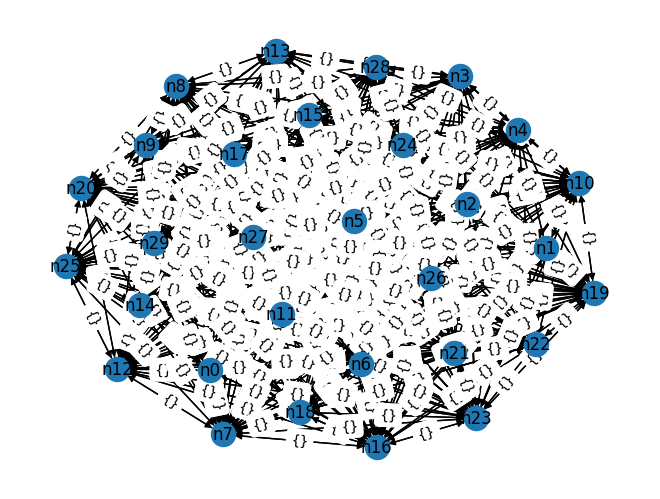

Streaming output truncated to the last 5000 lines.
               0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333]]),
       array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0.

,source,target,subnetwork_index,nsource,ntarget
0,0,1,0,n0,n1
1,0,2,0,n0,n2
2,0,3,0,n0,n3
3,0,4,0,n0,n4
4,1,0,0,n1,n0


Neighbor count min-max = 4-4


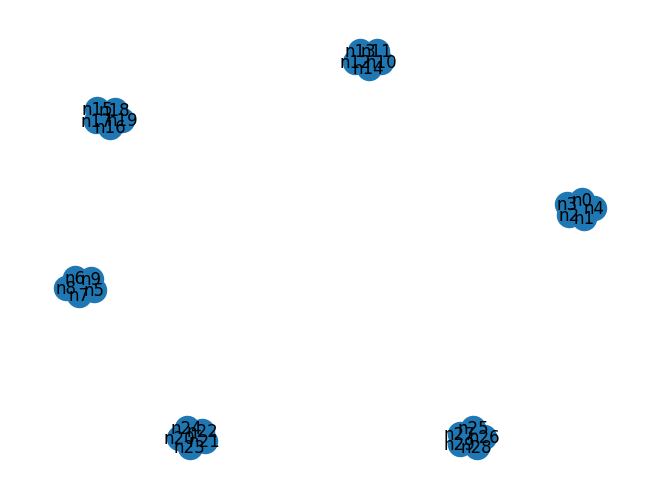

agent n0 : 0100000100 with fitness 14.343704898621867
agent n1 : 0101000000 with fitness 19.227616086702728
agent n2 : 0000000101 with fitness 16.20369515796789
agent n3 : 0001001010 with fitness 19.41793609271451
agent n4 : 1000100010 with fitness 19.135775187777842
agent n5 : 1000001001 with fitness 18.483249872350953
agent n6 : 0100010000 with fitness 19.9538650040185
agent n7 : 0010000010 with fitness 17.9559720692772
agent n8 : 1000001000 with fitness 11.272855711421004
agent n9 : 0011000000 with fitness 13.812629167770895
agent n10 : 0001000001 with fitness 14.151056970868156
agent n11 : 1000100000 with fitness 13.99061255097482
agent n12 : 0000100000 with fitness 7.4242421782068675
agent n13 : 0010000000 with fitness 8.777642338449652
agent n14 : 0000100000 with fitness 7.4242421782068675
agent n15 : 0000010010 with fitness 16.048653198663718
agent n16 : 0001001000 with fitness 11.935581521160916
agent n17 : 1001100000 with fitness 15.106432287562654
agent n18 : 0000100001 with 

In [ ]:
# Two-stage Sweep
# RUN the simulation
from datetime import datetime
import time
start_time = datetime.now()

T = 30                       # number of timesteps per trial
seed = 0

network_types = ['random','subgroups'] # list of network types to try ('random' and/or 'subgroups')

num_agents = 30  # set number of agents (for 'random' networks); 30 for tutorial simulation
p_rates = [1.0]   # list of connectivity rates to try (for 'random' networks)

N = 6  # number of subgroups (for 'subgroups' networks); 6 for tutorial simulation
M = 5  # agents per subgroup (for 'subgroups' networks); 5 for tutorial simulation

error_rates = [0.0]  # list error in copying rates to try

C_improvement_prefs = [np.array([5, -1, 0])]   # list of arrays to try for agent's preferences over outcomes (C^OUT)
learn_A_after_every_X_timesteps = [2]  # list of

# Additional parameters for building agents (additional modifications needed for compatibility)
inference_horizon = 2  # 2 for these simulations
policy_len = 1    # 1 for these simulations
inference_algo = 'MMP'  # 'MMP' for these simulations

results_all_trials = pd.DataFrame()  # Initialize dataframe for storing results of all trials
subnetwork_dict_all_trials = {}  # Initialize dictionary for storing results of all trials per subnetwork
trial = 0  # trial counter (sets index per trial and increments by 1 for each additional trial run)
for p in p_rates:
  for error_rate in error_rates:
    for C_improvement_pref in C_improvement_prefs:
      for learn_A_after_every_X_timesteps_i in learn_A_after_every_X_timesteps:
        for network_type in network_types:
          print(f"C_improvement_prefs = {C_improvement_pref}, error_rate = {error_rate}, p = {p}, learn_A_after_every_X_timesteps = {learn_A_after_every_X_timesteps_i}")
          try:
            err = 'create_agents_full_sweep'
            # Run full sweep given parameters
            agents_params, agents_list = create_agents_full_sweep(fitness_df, fitness_initial_df, num_agents=num_agents, num_neighbors=None, network_type=network_type, p=p, N=N, M=M, C_improvement_prefs=C_improvement_pref, seed=seed,
                                                                  inference_algo=inference_algo, inference_horizon=inference_horizon, policy_len = policy_len)
            print(f"BEFORE ACTINF LOOP: agents_params = len(agents_params)={len(agents_params)}, agents_params= {agents_params}")
            err = 'run_active_inference_loop'
            print("First stage")
            # Run Active Inference loop for stage 1
            results_one, all_solutions_final_one, all_fitnesses_final_one, all_solutions_start_one, all_fitnesses_start_one, subnetwork_dict_1 = run_active_inference_loop(agents_list, agents_params, fitness_df=fitness_df, T=T,
                                                                                                                                                        first_stage=True, error_rate = error_rate, learn_A_after_every_X_timesteps=learn_A_after_every_X_timesteps_i, error_monitoring=False)
            results_one['stage'] = 'First'
            for i in range(5):
              print("")
              print("stage 2")
            err = 'stage 2 initialize_solutions'
            print("Second Stage")
            # Initialize solutions for stage 2
            agents_list = initialize_solutions(agents_list=agents_list, fitness_initial_df=fitness_initial_df_two, fitness_df=fitness_df_two, seed=0)
            # Run ActInf loop for stage 2
            results_two, all_solutions_final_two, all_fitnesses_final_two, all_solutions_start_two, all_fitnesses_start_two, subnetwork_dict_2 = run_active_inference_loop(agents_list, agents_params, fitness_df=fitness_df_two, T=T,
                                                                                                                                                        first_stage=False, error_rate = error_rate, learn_A_after_every_X_timesteps=learn_A_after_every_X_timesteps_i,error_monitoring=False)
            results_two['stage'] = 'Second'
            results = pd.concat([results_one, results_two], ignore_index=True)
            results['error_rate'] = error_rate
            results['p'] = p
            results['C_improvement_prefs'] = str(C_improvement_pref)
            results['learn_A_after_every_X_timesteps'] = str(learn_A_after_every_X_timesteps_i)
            results['trial'] = trial
            results['network_type'] = network_type

            #Group-results
            for i in range(len(subnetwork_dict_1)):
              subnetwork_dict_1[i]['stage'] = ['First'] * len(subnetwork_dict_1[i]['avg_efe'])
              subnetwork_dict_2[i]['stage'] = ['Second'] * len(subnetwork_dict_2[i]['avg_efe'])

            subnetwork_dict = {key: { inner_key: subnetwork_dict_1[key][inner_key] + subnetwork_dict_2[key][inner_key] for inner_key in subnetwork_dict_1[key] } for key in subnetwork_dict_1 }
            for i in range(len(subnetwork_dict)):
              subnetwork_dict[i]['error_rate'] = [error_rate] * len(subnetwork_dict[i]['avg_efe'])
              subnetwork_dict[i]['p'] = [p] * len(subnetwork_dict[i]['avg_efe'])
              subnetwork_dict[i]['C_improvement_prefs'] = [C_improvement_prefs] * len(subnetwork_dict[i]['avg_efe'])
              subnetwork_dict[i]['learn_A_after_every_X_timesteps'] = [learn_A_after_every_X_timesteps] * len(subnetwork_dict[i]['avg_efe'])
              subnetwork_dict[i]['trial'] = [trial] * len(subnetwork_dict[i]['avg_efe'])
              subnetwork_dict[i]['network_type'] = [network_type] * len(subnetwork_dict[i]['avg_efe'])

            results_all_trials = pd.concat([results_all_trials, results]).reset_index(drop=True)
            subnetwork_dict_all_trials[trial] = subnetwork_dict
            trial +=1

          except Exception as e:
            print(f"Error at {err}: {e}")
            pass

end_time = datetime.now()
time_diff = end_time - start_time
print(f"Start: {start_time}, End: {end_time}, Time difference: {time_diff}")

In [ ]:
# display(results_all_trials[results_all_trials['trial'] == 1])
print(subnetwork_dict_all_trials[1])
print(len(subnetwork_dict_all_trials[1]))

{0: {'avg_all_agent_actions': [0.0, 1.0, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.8, 0.6, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.6, 0.6, 0.6, 0.6, 0.4, 0.6, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], 'number_of_unique_solutions': [5, 3, 4, 4, 4, 5, 4, 4, 3, 3, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 4, 4, 5, 5, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'min_fitness': [19.135775187777842, 25.257629340928485, 31.17200538854413, 36.34320613368487, 41.30041734802928, 41.30041734802928, 41.30041734802928, 41.30041734802928, 41.30041734802928, 41.30041734802928, 41.30041734802928, 42.31156429586, 42.31156429586, 46.33542571777882, 49.81580947804665, 49.81580947804665, 49.81580947804665, 51.496981399735795, 51.496981399735795, 51.496981399735795, 51.496981399735795, 61.454291281852456, 61.454291281852456, 6

Trial 0 results -------------------------------------------------


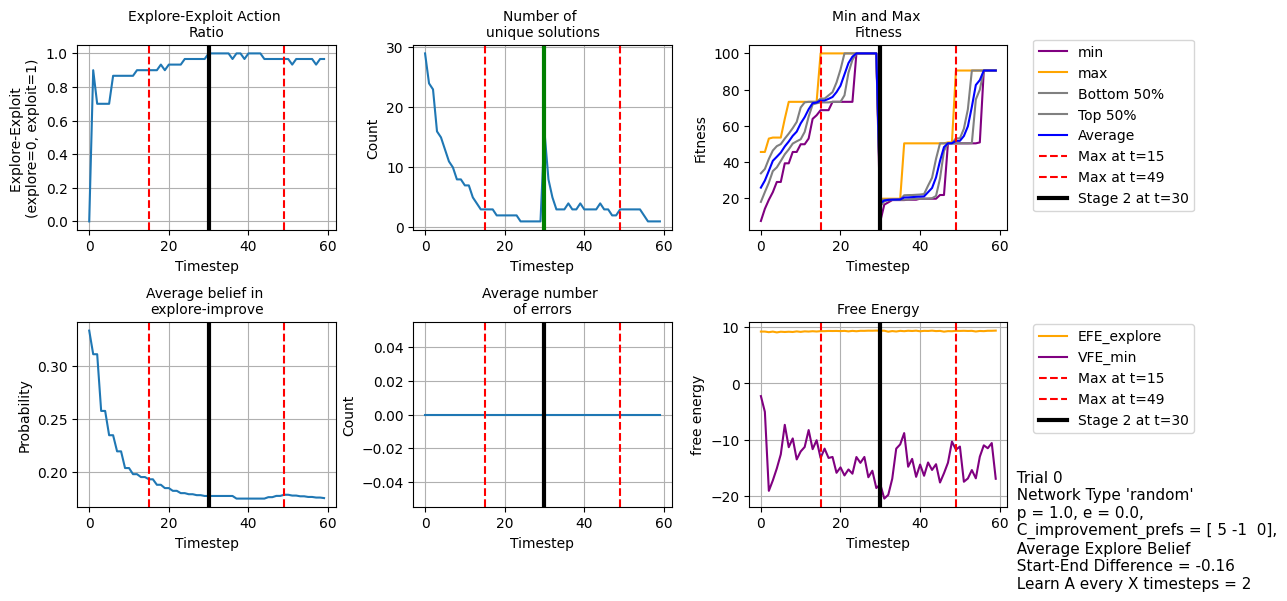

Trial 1 results -------------------------------------------------


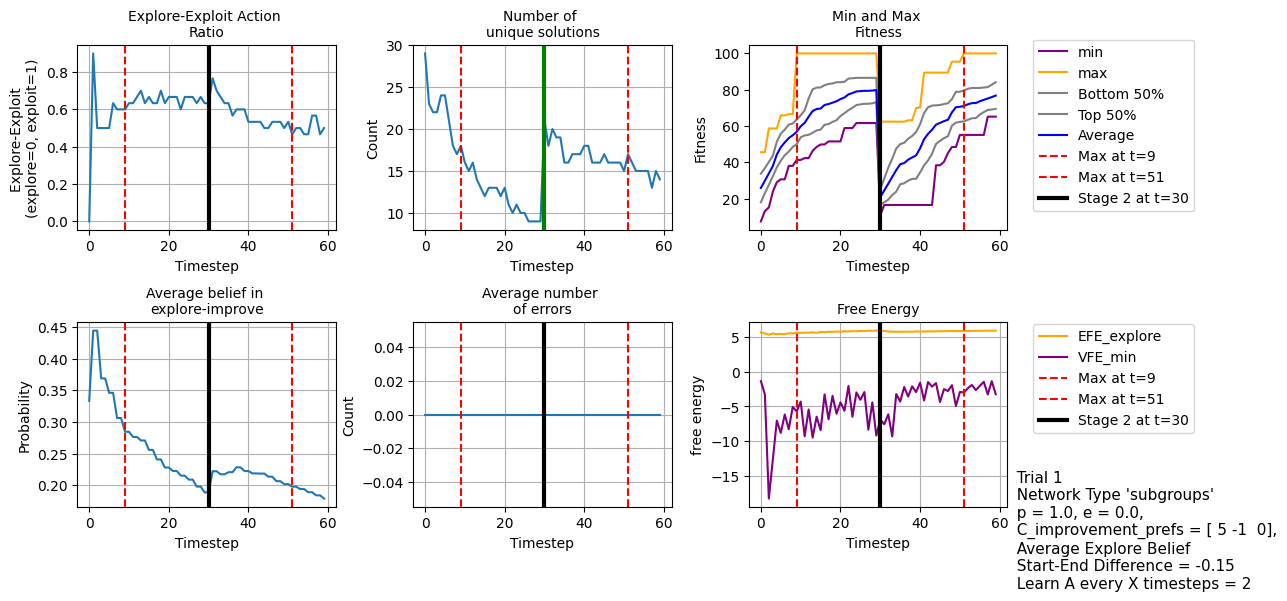

In [ ]:
# Plot results as subplots

import matplotlib.pyplot as plt
import numpy as np

def plot_results_stacked(results, fontsize=10):
  max_fitness_idx_1 = results[results['stage'] == 'First']['max_fitness'].idxmax()
  max_fitness_idx_2 = results[results['stage'] == 'Second']['max_fitness'].idxmax()
  # Find the row index where stage changes from 'First' to 'Second'
  stage_change_idx = results[results['stage'] == 'Second'].index[0]
  # Create a figure with 1 row and 5  columns of subplots
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

  axes[0,0].plot(results['avg_all_agent_actions'])
  axes[0,0].set_title("Explore-Exploit Action \nRatio", fontsize=fontsize)
  axes[0,0].set_xlabel('Timestep')
  axes[0,0].set_ylabel('Explore-Exploit \n(explore=0, exploit=1)')
  axes[0,0].axvline(x=max_fitness_idx_1, color='r', linestyle='--', label=f'Max at t={max_fitness_idx_1}')
  axes[0,0].axvline(x=max_fitness_idx_2, color='r', linestyle='--', label=f'Max at t={max_fitness_idx_2}')
  axes[0,0].axvline(x=stage_change_idx, color='black', linewidth=3, label=f'Stage 2 at t={stage_change_idx}')
  axes[0,0].grid()

  axes[0,1].plot(results['number_of_unique_solutions'])
  axes[0,1].set_title("Number of \nunique solutions", fontsize=fontsize)
  axes[0,1].set_xlabel('Timestep')
  axes[0,1].set_ylabel('Count')
  axes[0,1].axvline(x=max_fitness_idx_1, color='r', linestyle='--', label=f'Max at t={max_fitness_idx_1}')
  axes[0,1].axvline(x=max_fitness_idx_2, color='r', linestyle='--', label=f'Max at t={max_fitness_idx_2}')
  axes[0,1].axvline(x=stage_change_idx, color='g', linewidth=3, label=f'Stage 2 at t={stage_change_idx}')
  axes[0,1].grid()

  axes[0,2].plot(results['min_fitness'], color='purple', label='min')
  axes[0,2].plot(results['max_fitness'], color='orange', label='max')
  axes[0,2].plot(results['avg_bottom_50_fitness'], color = 'grey', label='Bottom 50%')
  axes[0,2].plot(results['avg_top_50_fitness'], color = 'grey', label='Top 50%')
  axes[0,2].plot(results['average_fitness'], color = 'blue', label='Average')
  axes[0,2].set_title("Fitness", fontsize=fontsize)
  axes[0,2].set_xlabel('Timestep')
  axes[0,2].set_ylabel('fitness')
  axes[0,2].legend()
  axes[0,2].grid()
  axes[0,2].set_title("Min and Max \nFitness", fontsize=fontsize)
  axes[0,2].set_xlabel('Timestep')
  axes[0,2].set_ylabel('Fitness')
  axes[0,2].axvline(x=max_fitness_idx_1, color='r', linestyle='--', label=f'Max at t={max_fitness_idx_1}')
  axes[0,2].axvline(x=max_fitness_idx_2, color='r', linestyle='--', label=f'Max at t={max_fitness_idx_2}')
  axes[0,2].axvline(x=stage_change_idx, color='black', linewidth=3, label=f'Stage 2 at t={stage_change_idx}')
  #axes[0,2].legend(loc='lower right')
  axes[0,2].legend(loc=(1.1,0.1))  #17/30, 300/600
  axes[0,2].grid()

  axes[1,0].plot(results['all_agents_A_explore_beliefs'])
  axes[1,0].set_title("Average belief in \nexplore-improve", fontsize=fontsize)
  axes[1,0].set_xlabel('Timestep')
  axes[1,0].set_ylabel('Probability')
  axes[1,0].axvline(x=max_fitness_idx_1, color='r', linestyle='--', label=f'Max at t={max_fitness_idx_1}')
  axes[1,0].axvline(x=max_fitness_idx_2, color='r', linestyle='--', label=f'Max at t={max_fitness_idx_2}')
  axes[1,0].axvline(x=stage_change_idx, color='black', linewidth=3, label=f'Stage 2 at t={stage_change_idx}')
  axes[1,0].grid()

  axes[1,1].plot(results['avg_all_agent_errors'])
  axes[1,1].set_title("Average number \nof errors", fontsize=fontsize)
  axes[1,1].set_xlabel('Timestep')
  axes[1,1].set_ylabel('Count')
  axes[1,1].axvline(x=max_fitness_idx_1, color='r', linestyle='--', label=f'Max at t={max_fitness_idx_1}')
  axes[1,1].axvline(x=max_fitness_idx_2, color='r', linestyle='--', label=f'Max at t={max_fitness_idx_2}')
  axes[1,1].axvline(x=stage_change_idx, color='black', linewidth=3, label=f'Stage 2 at t={stage_change_idx}')
  axes[1,1].grid()

  axes[1,2].plot(results['avg_efe'], color = 'orange', label = 'EFE_explore')
  axes[1,2].plot(results['avg_vfe'], color = 'purple', label = 'VFE_min')
  axes[1,2].set_title("Free Energy", fontsize=fontsize)
  axes[1,2].set_xlabel('Timestep')
  axes[1,2].set_ylabel('free energy')
  axes[1,2].axvline(x=max_fitness_idx_1, color='r', linestyle='--', label=f'Max at t={max_fitness_idx_1}')
  axes[1,2].axvline(x=max_fitness_idx_2, color='r', linestyle='--', label=f'Max at t={max_fitness_idx_2}')
  axes[1,2].axvline(x=stage_change_idx, color='black', linewidth=3, label=f'Stage 2 at t={stage_change_idx}')
  axes[1,2].legend(loc=(1.1,0.4))  #17/30, 300/600
  axes[1,2].grid()

  #if annotation_text:
  fig.suptitle(f"""
  Trial {results.iloc[0]['trial']}
  Network Type '{results.iloc[0]['network_type']}'
  p = {results.iloc[0]['p']}, e = {results.loc[0]['error_rate']},
  C_improvement_prefs = {results.loc[0]['C_improvement_prefs']},
  Average Explore Belief
  Start-End Difference = {round(results.iloc[len(results)-1]['all_agents_A_explore_beliefs'] - results.iloc[0]['all_agents_A_explore_beliefs'], 2)}
  Learn A every X timesteps = {results.iloc[0]['learn_A_after_every_X_timesteps']}""",
               fontsize=11, x=0.9, y=0.2, ha='left')
  #fig.suptitle(f"Trial {results.iloc[0]['trial']}", fontsize=14, x=0.1, y=0.5, ha='left')


  plt.subplots_adjust(wspace=0.3, hspace=0.5) # Adjust the spacing between subplots
  plt.show()

# Plot each trial's results
for trial in results_all_trials['trial'].unique():
  print(f"Trial {trial} results -------------------------------------------------")
  plot_results_stacked(results_all_trials[results_all_trials['trial'] == trial].reset_index(drop=True))

Trial 0: subnetwork 0


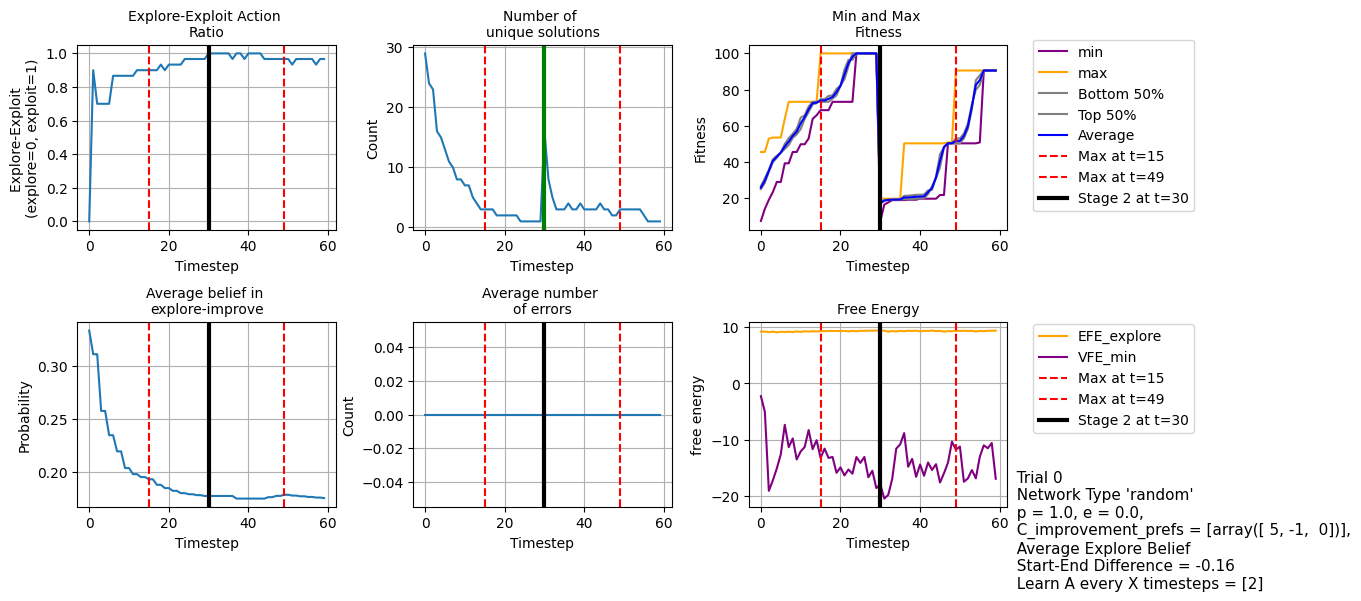

--------------------------------------------------------------
Trial 1: subnetwork 0


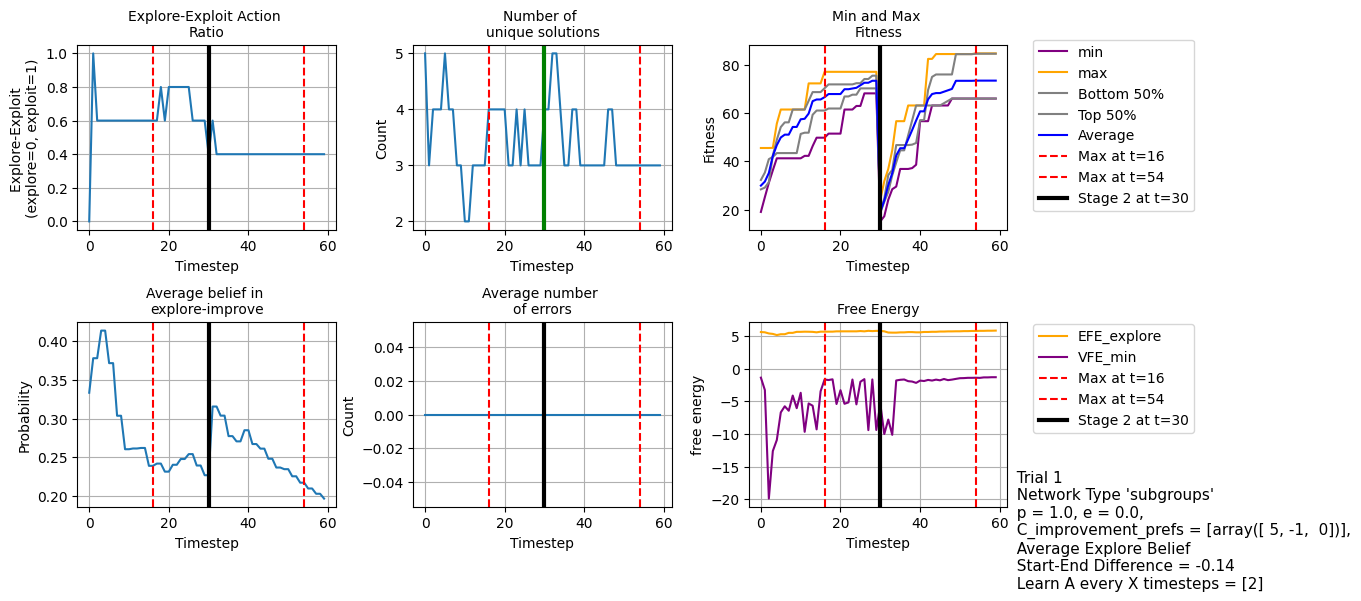

--------------------------------------------------------------
Trial 1: subnetwork 1


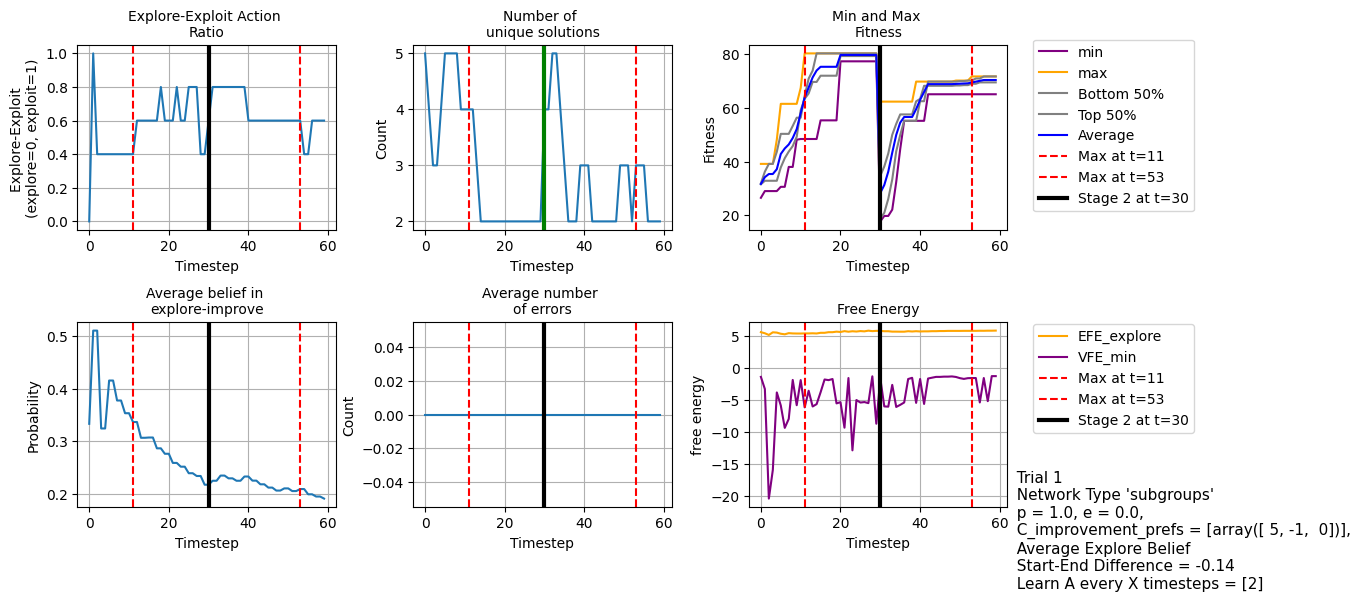

--------------------------------------------------------------
Trial 1: subnetwork 2


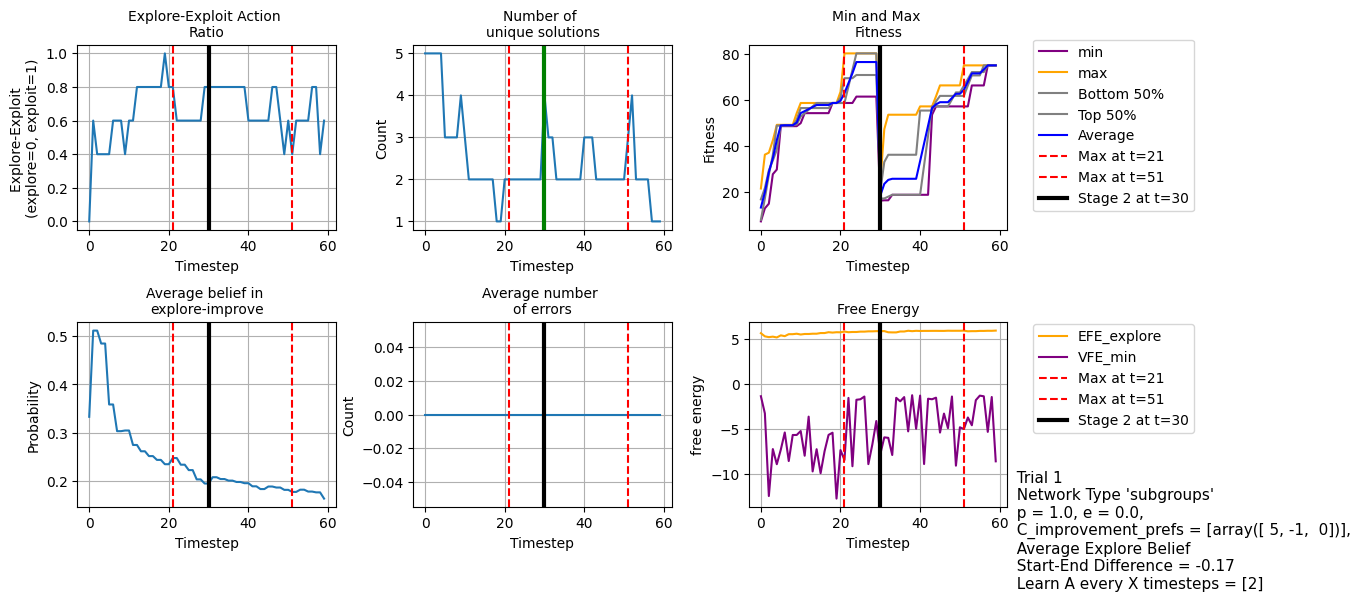

--------------------------------------------------------------
Trial 1: subnetwork 3


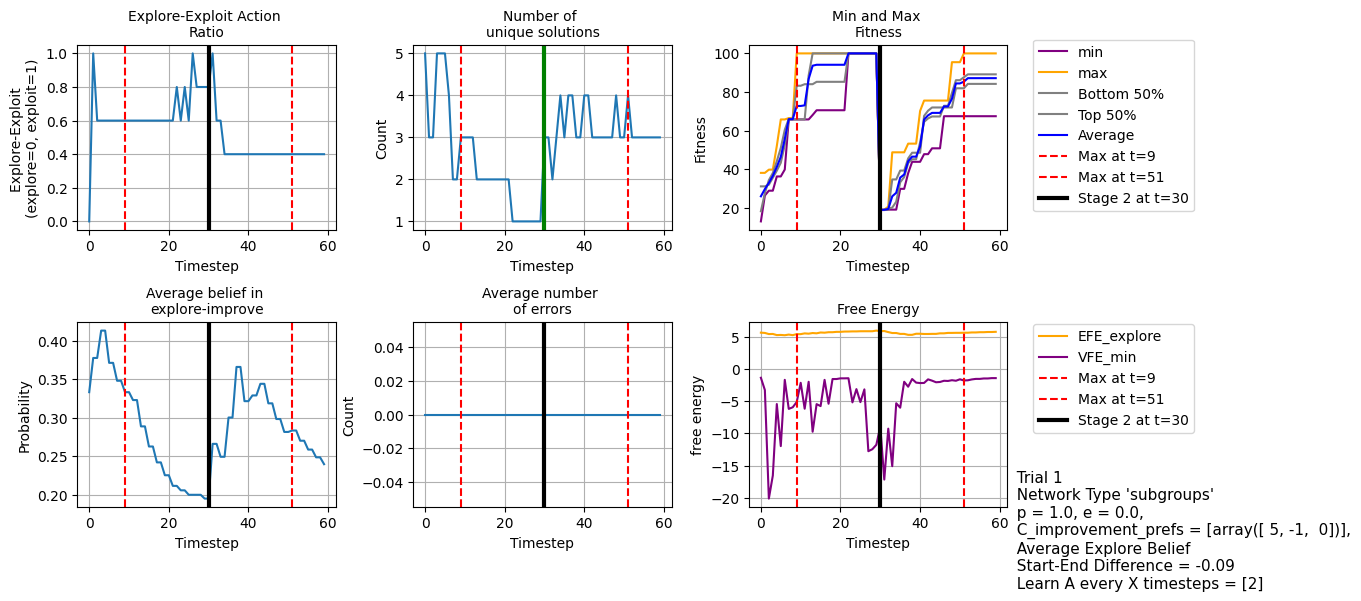

--------------------------------------------------------------
Trial 1: subnetwork 4


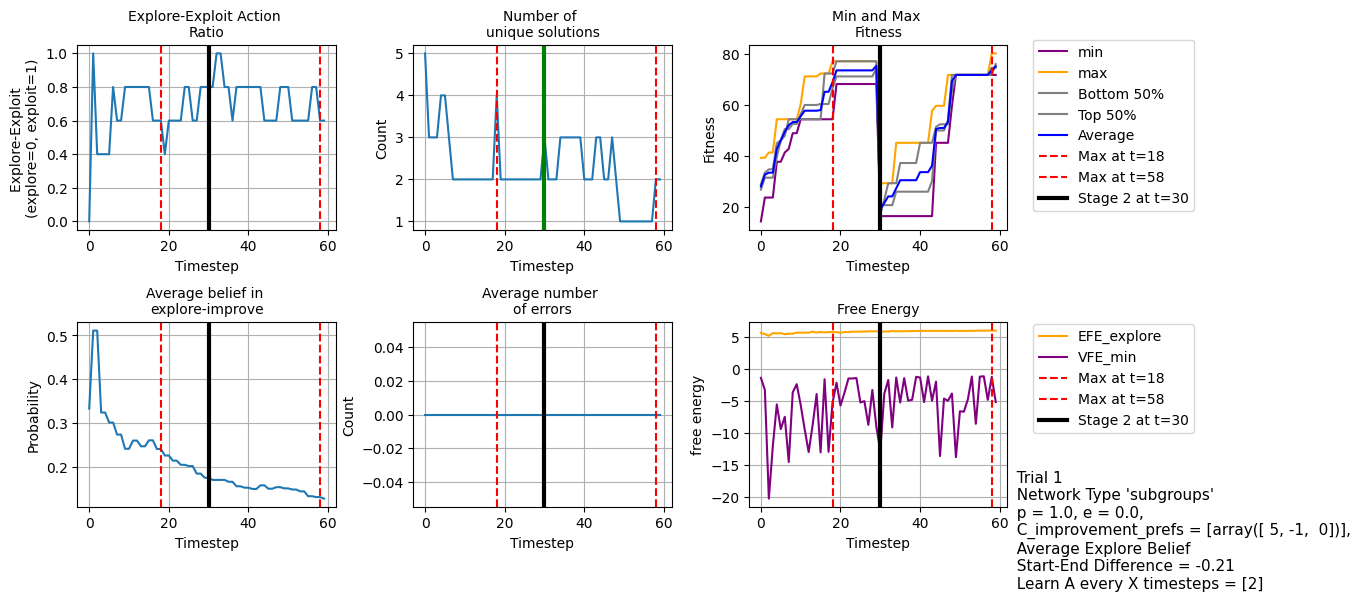

--------------------------------------------------------------
Trial 1: subnetwork 5


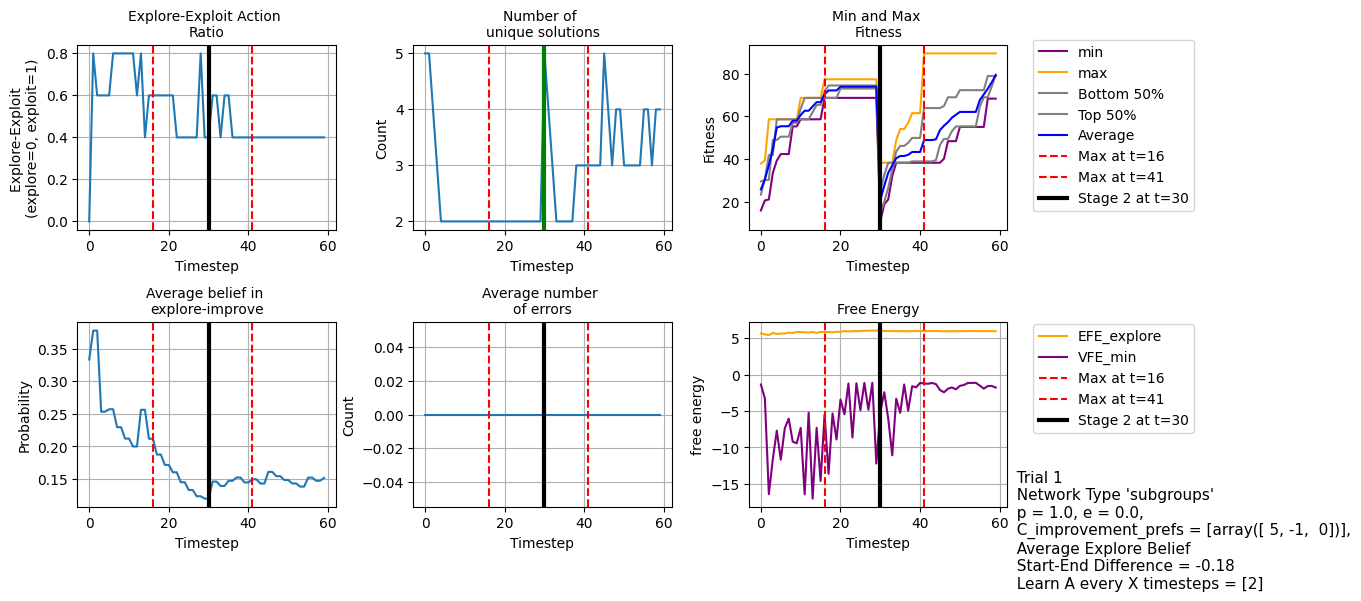

--------------------------------------------------------------


In [ ]:
# Plot results per subnetwork
for trial in range(len(subnetwork_dict_all_trials)):
  for subnetwork_i in range(len(subnetwork_dict_all_trials[trial])):
    print(f"Trial {trial}: subnetwork {subnetwork_i}")
    plot_results_stacked(pd.DataFrame(subnetwork_dict_all_trials[trial][subnetwork_i]))
    print(f"--------------------------------------------------------------")

In [ ]:
print(len(subnetwork_dict_all_trials))

2


In [ ]:
def plot_dist_animation(results, col):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from matplotlib import rc
    from IPython.display import HTML

    rc('animation', html='jshtml')
    all_data = []
    for i in range(len(results)):
        all_data.append(results.reset_index(drop=True)[col][i])
    fig, ax = plt.subplots()
    nbins = 15

    def animate(i):
        ax.clear()
        ax.hist(all_data[i], bins=nbins, density=False, range=(0,1))
        ax.set_title(f'Timestep: {i}')
        ax.set_ylabel('Count of agents')
        ax.set_xlabel(f'P(o=improvement|s=self) - {nbins} bins')
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(all_data[i]))
        ax.set_xticks(np.arange(0,1.1,0.1))
        for x_val in np.arange(0,1.1,0.1):
          ax.axvline(x=x_val,color='gray', linestyle=':', alpha=0.3, zorder=0)

    ani = animation.FuncAnimation(fig, animate, frames=len(all_data), repeat=False, interval=200)

    # Convert the animation to HTML
    html_animation = HTML(ani.to_html5_video())
    plt.close()
    return html_animation


for trial in results_all_trials['trial'].unique():
  print(f"Trial = {trial}")
  df_t = results_all_trials[results_all_trials['trial'] == trial]
  #display(df_t['all_agents_A_explore_beliefs_dist'].head(5))
  ani = plot_dist_animation(results=df_t, col='all_agents_A_explore_beliefs_dist')
  display(ani)

Trial = 0


Trial = 1
